In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM

In [5]:
#AGREGA AQUI TODAS LAS ESTACIONES

estaciones = ['BOLIVIA', 'BOSA', 'CARVAJAL', 'CENTRO DE ALTO RENDIMIENTO', 'CIUDAD BOLIVAR', 'FONTIBON', 'GUAYMARAL', 'JAZMIN','KENNEDY','LAS FERIAS','MIN AMBIENTE','PUENTE ARANDA','SAN CRISTOBAL','SUBA','TUNAL','USAQUEN','USME']

datos = {}

ozo = pd.read_csv('SALIDAS/llenado_O3.csv')
no = pd.read_csv('SALIDAS/llenado_NO.csv')
no2 = pd.read_csv('SALIDAS/llenado_NO2.csv')
co = pd.read_csv('SALIDAS/llenado_CO.csv')
pm10 = pd.read_csv('SALIDAS/llenado_PM10.csv')
pm25 = pd.read_csv('SALIDAS/llenado_PM25.csv')
rad = pd.read_csv('SALIDAS/llenado_RADf.csv')
spe = pd.read_csv('SALIDAS/llenado_VELf.csv')
RH = pd.read_csv('SALIDAS/llenado_HRf.csv')
T2 = pd.read_csv('SALIDAS/llenado_TEMf.csv')
UU= pd.read_csv('SALIDAS/llenado_u-component.csv')
VV= pd.read_csv('SALIDAS/llenado_v-component.csv')


columnas = ['o3', 'no', 'no2', 'co', 'pm10', 'pm25', 'rad', 'vel', 'rh', 't2','uu','vv']

for estacion in estaciones:
    datos_estacion = np.column_stack((
        ozo[estacion],
        no[estacion],
        no2[estacion],
        co[estacion],
        pm10[estacion],
        pm25[estacion],
        rad[estacion],
        spe[estacion],
        RH[estacion],
        T2[estacion],
        UU['MEAN'],
        VV['MEAN']
    ))
    datos[estacion] = datos_estacion

dataframes_estaciones = {}
for estacion in estaciones:
    df_estacion = pd.DataFrame(datos[estacion], columns=columnas)
    dataframes_estaciones[estacion] = df_estacion

In [6]:
def crear_trenes(dataset):
    x_train = []
    y_train = []
    
    for index_inicial in np.arange(0,len(dataset)-n_pasos,1):
        index_final = index_inicial + n_pasos
        
        secuencia_x = dataset[index_inicial:index_final, :-1]
        secuencia_y = dataset[index_final-1,-1]
        
        x_train.append(secuencia_x)
        y_train.append(secuencia_y)
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    return(x_train,y_train)

In [7]:
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [8]:
def train_and_predict_model(X_train, y_train, X_test, y_test):
    model = Sequential([
        layers.Input(shape=X_train.shape[1:]),  # Capa de entrada
        layers.Conv1D(16, kernel_size=3, activation='relu'),  # Capa de convolución 1D con 16 filtros
        layers.Conv1D(32, kernel_size=3, activation='relu'),  # Capa de convolución 1D con 32 filtros
        layers.Conv1D(64, kernel_size=3, activation='relu'),  # Capa de convolución 1D con 64 filtros
        layers.BatchNormalization(),  # Capa de BatchNormalization
        layers.Bidirectional(LSTM(32, dropout=0.2, return_sequences=True)), # Capa Bidirectional LSTM con 32 neuronas y 20% dropout
        layers.BatchNormalization(),  # Capa de BatchNormalization
        layers.Bidirectional(LSTM(16, dropout=0.2)), # Capa Bidirectional LSTM con 16 neuronas y 20% dropout
        layers.BatchNormalization(),  # Capa de BatchNormalization
        layers.Flatten(),  # Capa para aplanar la salida de la capa de LSTM
        layers.Dense(32, activation='relu'),  # Capa Densa con 32 neuronas
        layers.BatchNormalization(),  # Capa de BatchNormalization
        layers.Dense(32, activation='relu'),  # Capa Densa con 32 neuronas
        layers.BatchNormalization(),  # Capa de BatchNormalization
        layers.Dense(24, activation='relu'),  # Capa Densa con 24 neuronas
    ])
    
    model.compile(optimizer='adam', loss='msle', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)
    history = model.fit(X_train, y_train, batch_size=10, epochs=1)
  
    
    prediccion = model.predict(X_test)
    real = invTransform(escalador, y_test, columnas[-1], columnas)
    prediccion = invTransform(escalador, prediccion, columnas[-1], columnas)
    
    return model


In [2]:
import matplotlib.pyplot as plt

Epoch 1/25
1164/1164 - 41s - loss: 0.0243 - accuracy: 0.0000e+00 - val_loss: 0.0082 - val_accuracy: 0.0000e+00 - 41s/epoch - 36ms/step
Epoch 2/25
1164/1164 - 32s - loss: 0.0077 - accuracy: 0.0000e+00 - val_loss: 0.3109 - val_accuracy: 0.0000e+00 - 32s/epoch - 28ms/step
Epoch 3/25
1164/1164 - 34s - loss: 0.0062 - accuracy: 0.0000e+00 - val_loss: 0.0282 - val_accuracy: 0.0000e+00 - 34s/epoch - 29ms/step
Epoch 4/25
1164/1164 - 34s - loss: 0.0054 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00 - 34s/epoch - 30ms/step
Epoch 5/25
1164/1164 - 32s - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00 - 32s/epoch - 28ms/step
Epoch 6/25
1164/1164 - 32s - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0030 - val_accuracy: 0.0000e+00 - 32s/epoch - 28ms/step
Epoch 7/25
1164/1164 - 32s - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0055 - val_accuracy: 0.0000e+00 - 32s/epoch - 28ms/step
Epoch 8/25
1164/1164 - 33s - loss: 0.0045 - accuracy: 0

Epoch 9/25
1164/1164 - 31s - loss: 0.0043 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.0000e+00 - 31s/epoch - 27ms/step
Epoch 10/25
1164/1164 - 31s - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00 - 31s/epoch - 27ms/step
Epoch 11/25
1164/1164 - 31s - loss: 0.0043 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00 - 31s/epoch - 27ms/step
Epoch 12/25
1164/1164 - 32s - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00 - 32s/epoch - 27ms/step
Epoch 13/25
1164/1164 - 32s - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00 - 32s/epoch - 27ms/step
Epoch 14/25
1164/1164 - 30s - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00 - 30s/epoch - 26ms/step
Epoch 15/25
1164/1164 - 31s - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - 31s/epoch - 27ms/step
Epoch 16/25
1164/1164 - 31s - loss: 0.0041 - accu

Epoch 17/25
1164/1164 - 32s - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00 - 32s/epoch - 27ms/step
Epoch 18/25
1164/1164 - 31s - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00 - 31s/epoch - 27ms/step
Epoch 19/25
1164/1164 - 32s - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - 32s/epoch - 27ms/step
Epoch 20/25
1164/1164 - 32s - loss: 0.0046 - accuracy: 1.3427e-05 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - 32s/epoch - 27ms/step
Epoch 21/25
1164/1164 - 32s - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - 32s/epoch - 27ms/step
Epoch 22/25
1164/1164 - 32s - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00 - 32s/epoch - 27ms/step
Epoch 23/25
1164/1164 - 32s - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00 - 32s/epoch - 27ms/step
Epoch 24/25
1164/1164 - 31s - loss: 0.0046 - acc

Epoch 25/25
1164/1164 - 33s - loss: 0.0040 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - 33s/epoch - 28ms/step
411/411 [==============================] - 3s 6ms/step
Epoch 1/25
1164/1164 - 41s - loss: 0.0216 - accuracy: 0.0000e+00 - val_loss: 0.0297 - val_accuracy: 0.0000e+00 - 41s/epoch - 35ms/step
Epoch 2/25
1164/1164 - 30s - loss: 0.0070 - accuracy: 0.0000e+00 - val_loss: 0.0051 - val_accuracy: 0.0000e+00 - 30s/epoch - 26ms/step
Epoch 3/25
1164/1164 - 31s - loss: 0.0054 - accuracy: 0.0000e+00 - val_loss: 0.0041 - val_accuracy: 0.0000e+00 - 31s/epoch - 26ms/step
Epoch 4/25
1164/1164 - 31s - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0053 - val_accuracy: 0.0000e+00 - 31s/epoch - 27ms/step
Epoch 5/25
1164/1164 - 31s - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00 - 31s/epoch - 27ms/step
Epoch 6/25
1164/1164 - 32s - loss: 0.0048 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00 - 32s/epoch - 27ms/step

Epoch 6/25
1164/1164 - 32s - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0048 - val_accuracy: 0.0000e+00 - 32s/epoch - 27ms/step
Epoch 7/25
1164/1164 - 32s - loss: 0.0048 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00 - 32s/epoch - 27ms/step
Epoch 8/25
1164/1164 - 32s - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00 - 32s/epoch - 27ms/step
Epoch 9/25
1164/1164 - 32s - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00 - 32s/epoch - 27ms/step
Epoch 10/25
1164/1164 - 32s - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00 - 32s/epoch - 28ms/step
Epoch 11/25
1164/1164 - 32s - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00 - 32s/epoch - 28ms/step
Epoch 12/25
1164/1164 - 32s - loss: 0.0046 - accuracy: 1.3427e-05 - val_loss: 0.0031 - val_accuracy: 0.0000e+00 - 32s/epoch - 27ms/step
Epoch 13/25
1164/1164 - 31s - loss: 0.0046 - accurac

Epoch 14/25
1164/1164 - 31s - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00 - 31s/epoch - 27ms/step
Epoch 15/25
1164/1164 - 31s - loss: 0.0046 - accuracy: 1.3427e-05 - val_loss: 0.0025 - val_accuracy: 0.0000e+00 - 31s/epoch - 26ms/step
Epoch 16/25
1164/1164 - 29s - loss: 0.0045 - accuracy: 1.3427e-05 - val_loss: 0.0028 - val_accuracy: 0.0000e+00 - 29s/epoch - 25ms/step
Epoch 17/25
1164/1164 - 28s - loss: 0.0045 - accuracy: 1.3427e-05 - val_loss: 0.0028 - val_accuracy: 0.0000e+00 - 28s/epoch - 24ms/step
Epoch 18/25
1164/1164 - 28s - loss: 0.0045 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00 - 28s/epoch - 24ms/step
Epoch 19/25
1164/1164 - 28s - loss: 0.0045 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00 - 28s/epoch - 24ms/step
Epoch 20/25
1164/1164 - 29s - loss: 0.0045 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00 - 29s/epoch - 24ms/step
Epoch 21/25
1164/1164 - 29s - loss: 0.0044 - acc

Epoch 22/25
1164/1164 - 27s - loss: 0.0043 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00 - 27s/epoch - 23ms/step
Epoch 23/25
1164/1164 - 28s - loss: 0.0043 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00 - 28s/epoch - 24ms/step
Epoch 24/25
1164/1164 - 30s - loss: 0.0043 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.0000e+00 - 30s/epoch - 26ms/step
Epoch 25/25
1164/1164 - 30s - loss: 0.0043 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00 - 30s/epoch - 26ms/step
411/411 [==============================] - 2s 5ms/step
Epoch 1/25
1164/1164 - 38s - loss: 0.0241 - accuracy: 1.3427e-05 - val_loss: 0.0092 - val_accuracy: 0.0000e+00 - 38s/epoch - 32ms/step
Epoch 2/25
1164/1164 - 29s - loss: 0.0065 - accuracy: 0.0000e+00 - val_loss: 0.0052 - val_accuracy: 0.0000e+00 - 29s/epoch - 25ms/step
Epoch 3/25
1164/1164 - 29s - loss: 0.0061 - accuracy: 0.0000e+00 - val_loss: 0.0048 - val_accuracy: 0.0000e+00 - 29s/epoch - 25ms/s

Epoch 3/25
1164/1164 - 27s - loss: 0.0060 - accuracy: 0.0000e+00 - val_loss: 0.0053 - val_accuracy: 0.0000e+00 - 27s/epoch - 23ms/step
Epoch 4/25
1164/1164 - 28s - loss: 0.0056 - accuracy: 0.0000e+00 - val_loss: 0.0080 - val_accuracy: 0.0000e+00 - 28s/epoch - 24ms/step
Epoch 5/25
1164/1164 - 27s - loss: 0.0051 - accuracy: 0.0000e+00 - val_loss: 0.0036 - val_accuracy: 0.0000e+00 - 27s/epoch - 24ms/step
Epoch 6/25
1164/1164 - 28s - loss: 0.0051 - accuracy: 0.0000e+00 - val_loss: 0.0043 - val_accuracy: 0.0000e+00 - 28s/epoch - 24ms/step
Epoch 7/25
1164/1164 - 28s - loss: 0.0048 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00 - 28s/epoch - 24ms/step
Epoch 8/25
1164/1164 - 28s - loss: 0.0048 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00 - 28s/epoch - 24ms/step
Epoch 9/25
1164/1164 - 27s - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00 - 27s/epoch - 23ms/step
Epoch 10/25
1164/1164 - 27s - loss: 0.0047 - accuracy: 

NameError: name 'j' is not defined

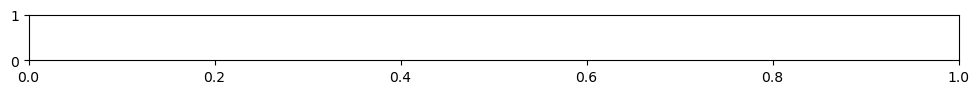

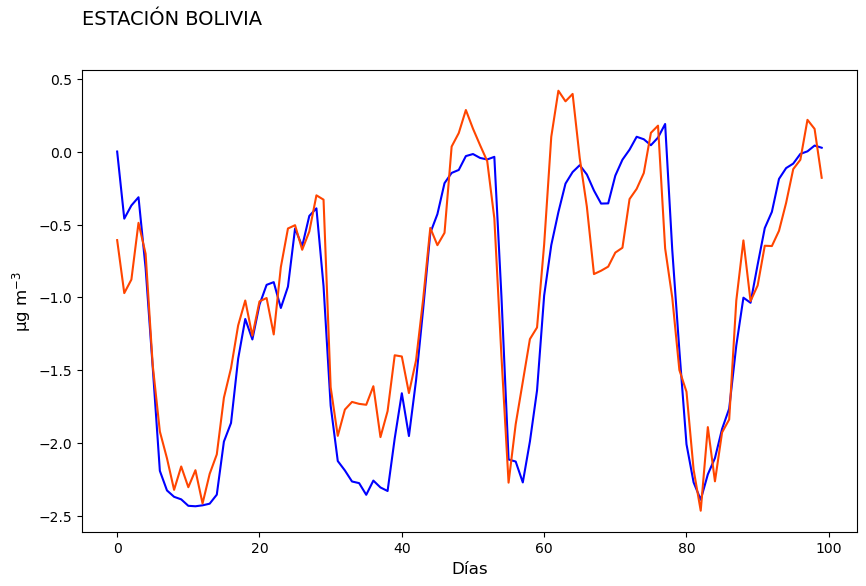

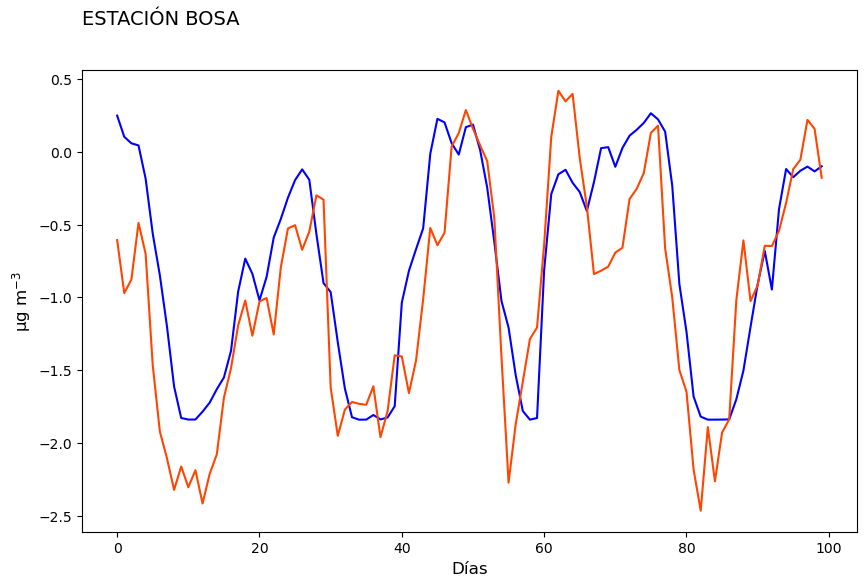

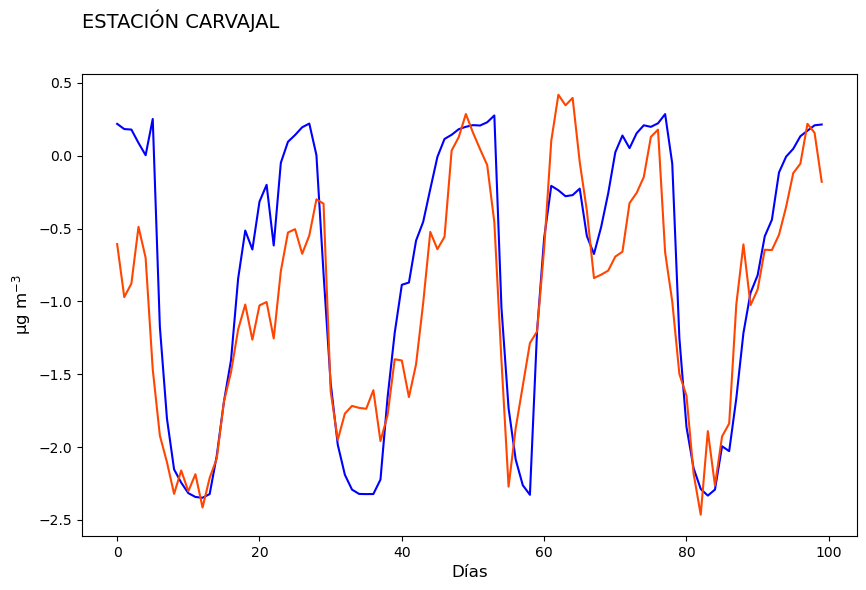

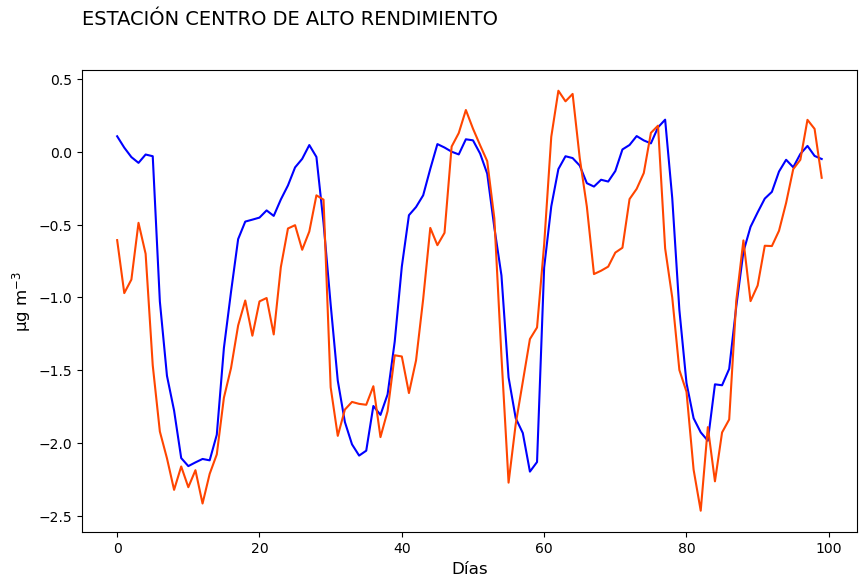

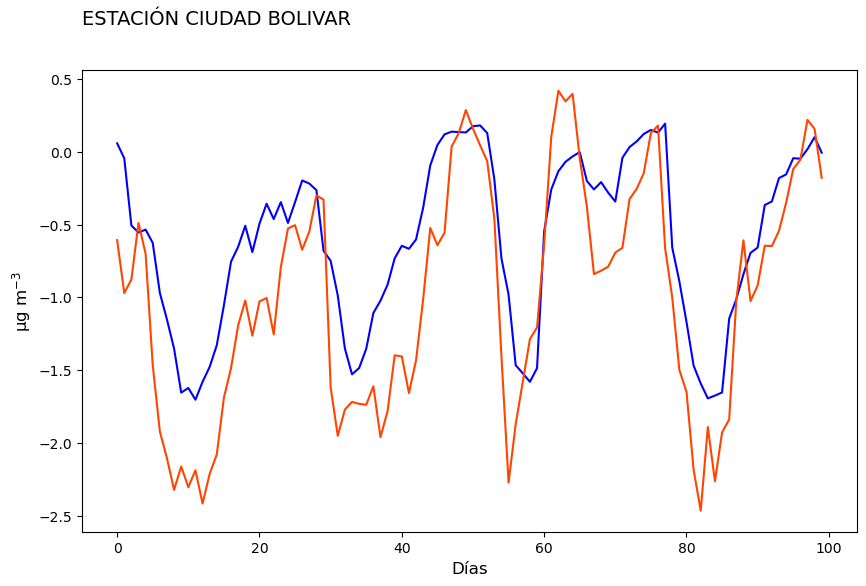

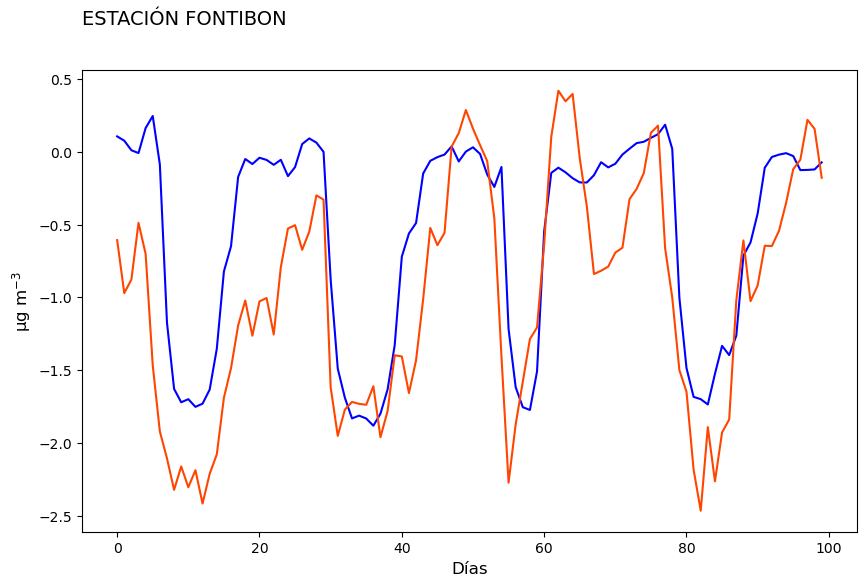

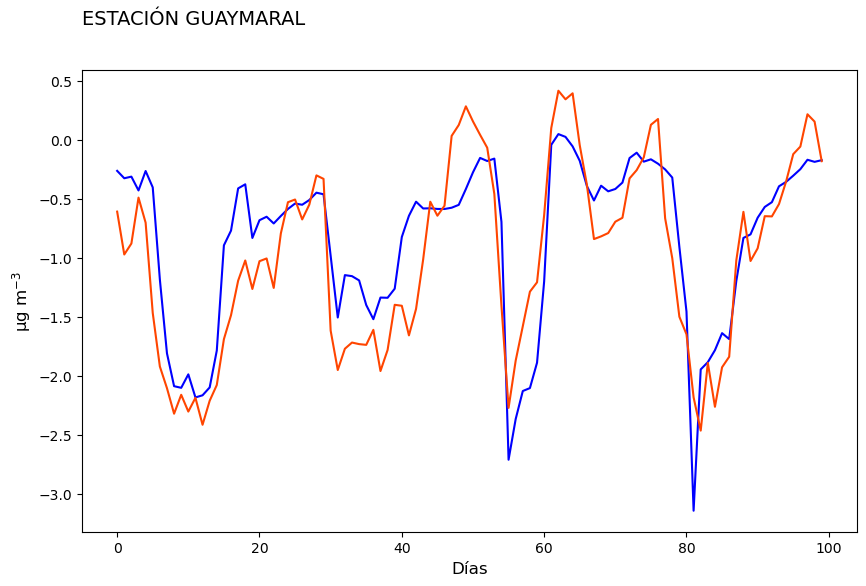

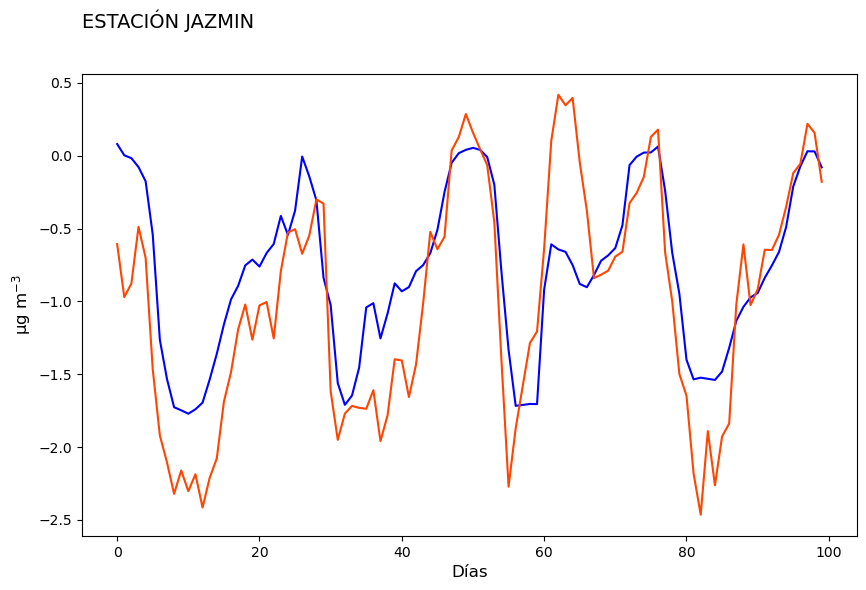

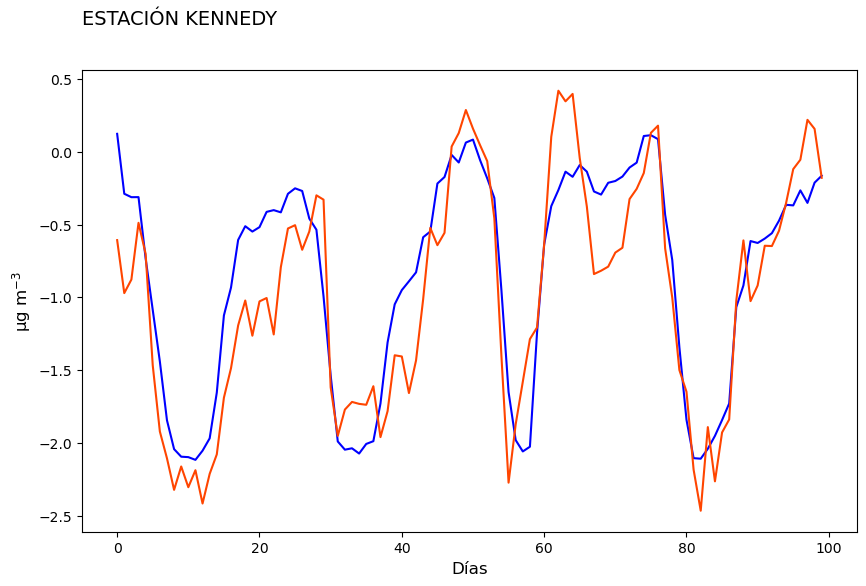

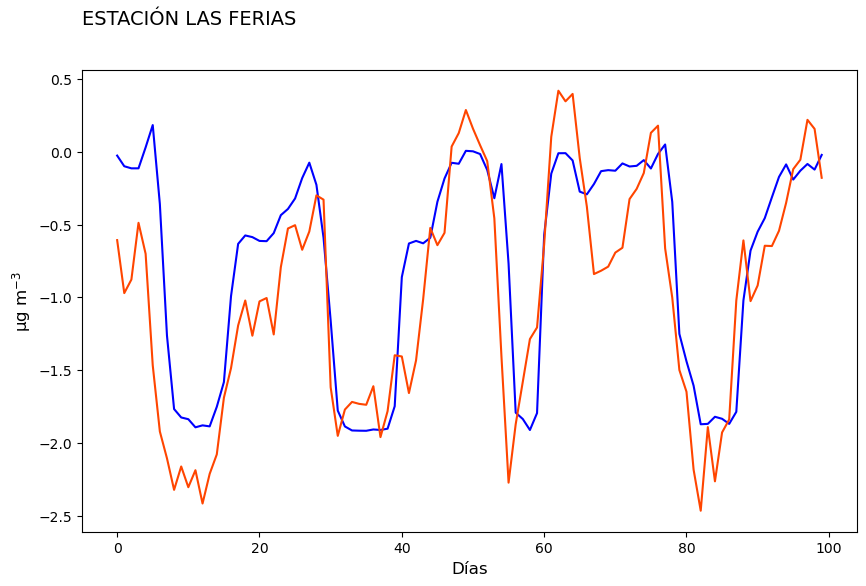

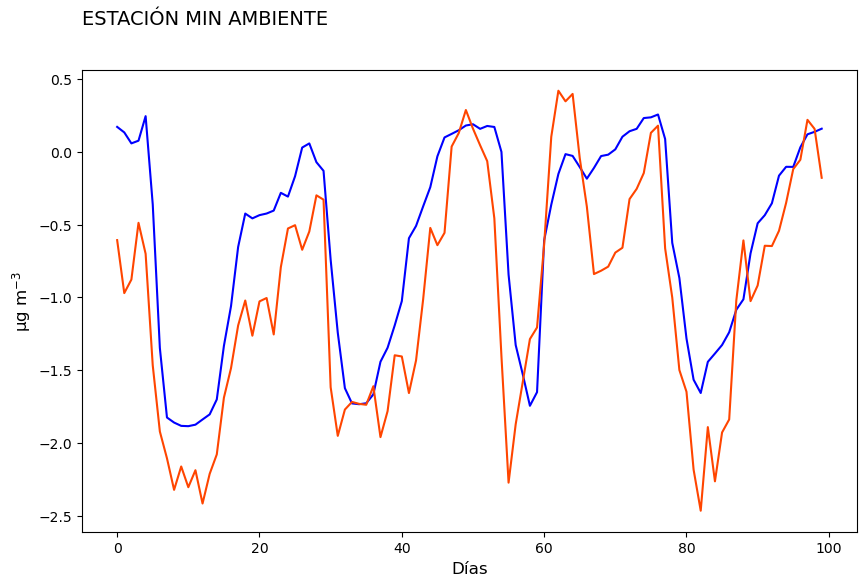

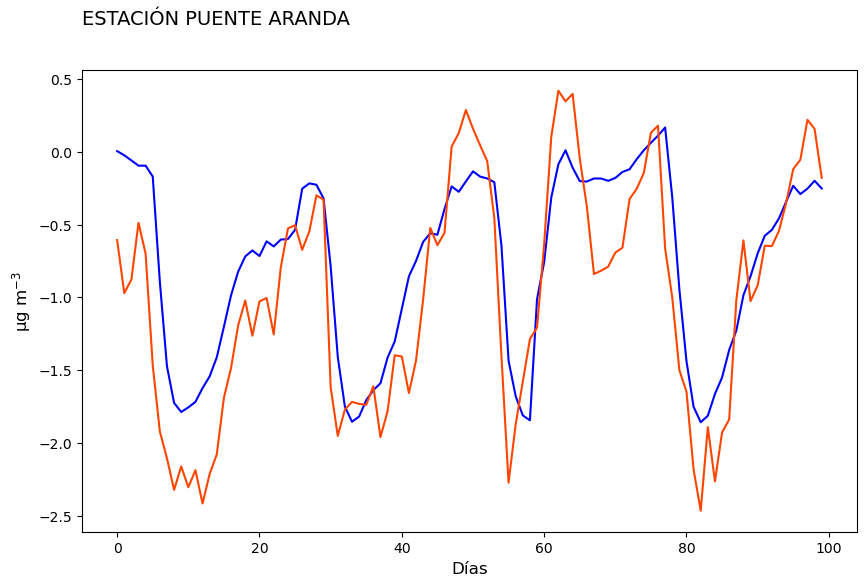

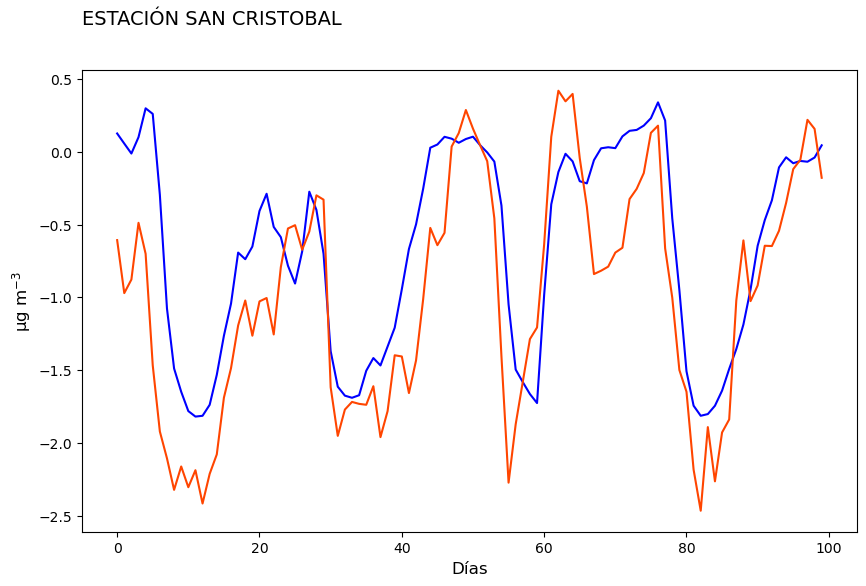

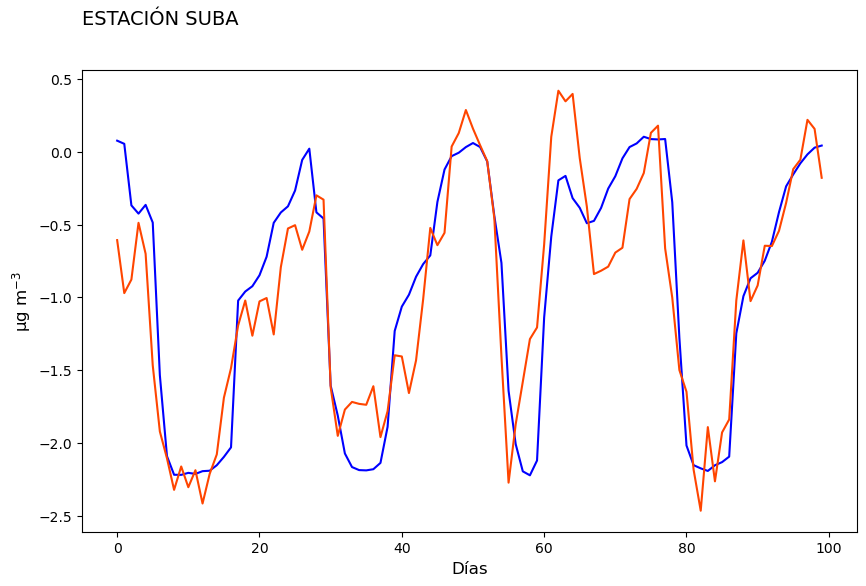

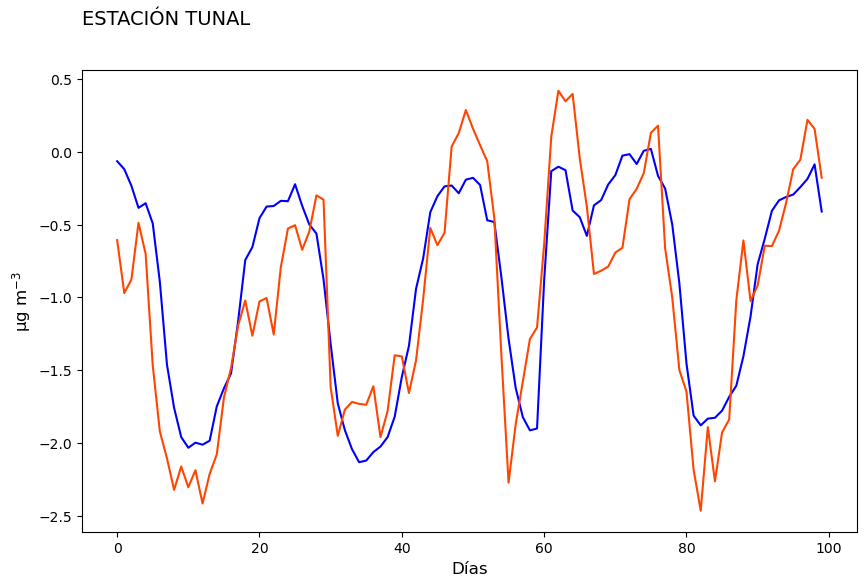

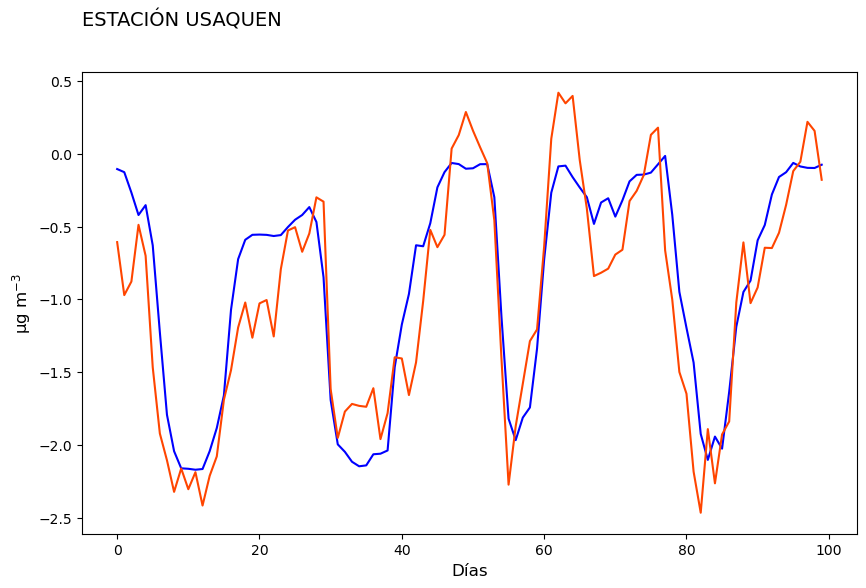

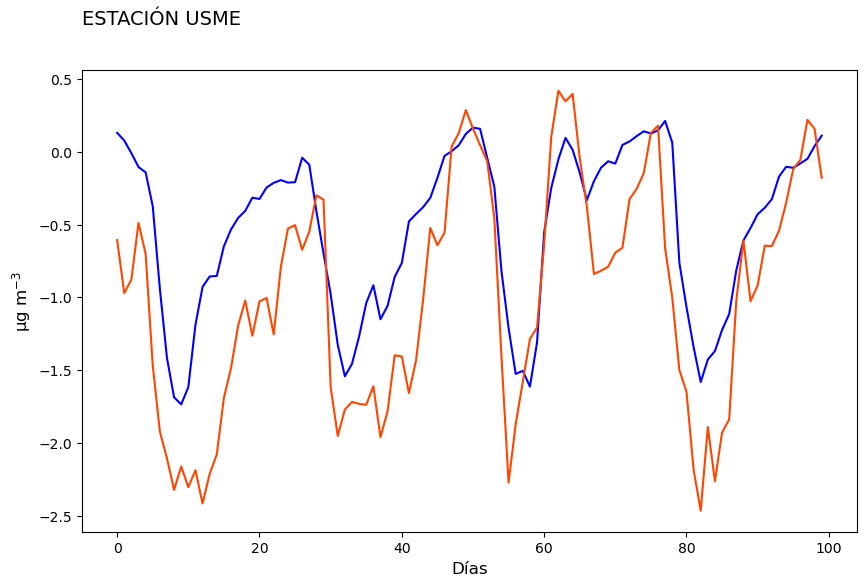

In [14]:
fig_combined = plt.figure(figsize=(12, 12))

individual_figures = []

# Itera a través de las estaciones
for estacion in estaciones:
    df_estacion = dataframes_estaciones[estacion]
    
   
    n_pasos = 24
    escalador = MinMaxScaler(feature_range=(0, 1))
    escalador.fit(df_estacion)
    
    data_nor = escalador.transform(df_estacion)
    data_train = data_nor[0:int(len(df_estacion) * 0.85)]
    data_test = data_nor[int(len(df_estacion) * 0.85):]
    
    X_train, y_train = crear_trenes(data_train)
    X_test, y_test = crear_trenes(data_test)
    
    # Llama a la función de entrenamiento y predicción del modelo
    trained_model = train_and_predict_model(X_train, y_train, X_test, y_test)
    
  
    prediccion = trained_model.predict(X_test)
    
    real = invTransform(escalador, y_test, columnas[-1], columnas)
    prediccion = invTransform(escalador, prediccion, columnas[-1], columnas)
    
    
    # Ruta del archivo CSV para guardar las predicciones
    csv_filename = f'prediccion_estacion_{estacion}.csv' #Va a quedar en el directorio actual- pagina principal 

    # Guardar las predicciones en un archivo CSV
    prediccion_df = pd.DataFrame({'Prediccion': prediccion, 'Real': real})
    prediccion_df.to_csv(csv_filename, index=False)
    # Crea una figura y un subplot para la estación actual
    fig_individual = plt.figure(figsize=(10, 6))
    plt.title(f'ESTACIÓN {estacion}', fontsize=14, loc='left', y=1.08)
    
    # Grafica la predicción y los datos reales para los primeros 100 días
    plt.plot(prediccion[0:100], label='Predicción Ozono', color='blue')
    plt.plot(real[0:100], label='Ozono observado', color='orangered')
    
    plt.xlabel('Días', fontsize=12)
    plt.ylabel('μg m$^{-3}$', fontsize=12)
    
    individual_figures.append(fig_individual)  # Agrega la figura individual a la lista

# Combinar las figuras individuales en una sola figura con subtramas
for i, fig in enumerate(individual_figures):
    sub = fig_combined.add_subplot(len(estaciones), 1, i+1)
    plt.title(f'{chr(97 + i * 3 + j)} {estacion}', fontsize=14, loc='left', y=1.08)
    if i == 1:   
        plt.legend(frameon=False, bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=4, fontsize=10)
    sub.axis('off')  # Desactivar ejes para la figura combinada
    sub.imshow(fig)

plt.show()  # Muestra la figura combinada

In [7]:
##GRÁFICAS PARA TESIS

estaciones = ['BOLIVIA', 'BOSA', 'CARVAJAL', 'CENTRO DE ALTO RENDIMIENTO', 'CIUDAD BOLIVAR', 'FONTIBON', 'GUAYMARAL', 'JAZMIN','KENNEDY','LAS FERIAS','MIN AMBIENTE','PUENTE ARANDA','SAN CRISTOBAL','SUBA','TUNAL','USAQUEN','USME']
datos = {}
df1 = pd.read_csv('Prediccion/prediccion_estacion_BOLIVIA.csv')
df2 = pd.read_csv('Prediccion/prediccion_estacion_BOSA.csv')
df3 = pd.read_csv('Prediccion/prediccion_estacion_CARVAJAL.csv')
df4 = pd.read_csv('Prediccion/prediccion_estacion_CENTRO DE ALTO RENDIMIENTO.csv')
df5 = pd.read_csv('Prediccion/prediccion_estacion_CIUDAD BOLIVAR.csv')
df = pd.read_csv('Prediccion/prediccion_estacion_FONTIBON.csv')
df = pd.read_csv('Prediccion/prediccion_estacion_GUAYMARAL.csv')
df = pd.read_csv('Prediccion/prediccion_estacion_JAZMIN.csv')
df = pd.read_csv('Prediccion/prediccion_estacion_KENNEDY.csv')
df = pd.read_csv('Prediccion/prediccion_estacion_LAS FERIAS.csv')
df = pd.read_csv('Prediccion/prediccion_estacion_MIN AMBIENTE.csv')
df = pd.read_csv('Prediccion/prediccion_estacion_PUENTE ARANDA.csv')
df = pd.read_csv('Prediccion/prediccion_estacion_SAN CRISTOBAL.csv')
df = pd.read_csv('Prediccion/prediccion_estacion_SUBA.csv')
df = pd.read_csv('Prediccion/prediccion_estacion_TUNAL.csv')
df = pd.read_csv('Prediccion/prediccion_estacion_USAQUEN.csv')
df = pd.read_csv('Prediccion/prediccion_estacion_USME.csv')

NameError: name 'j' is not defined

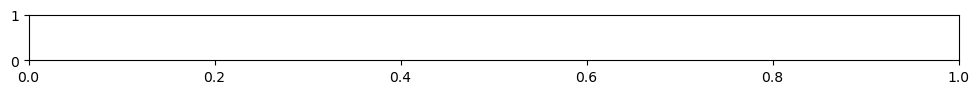

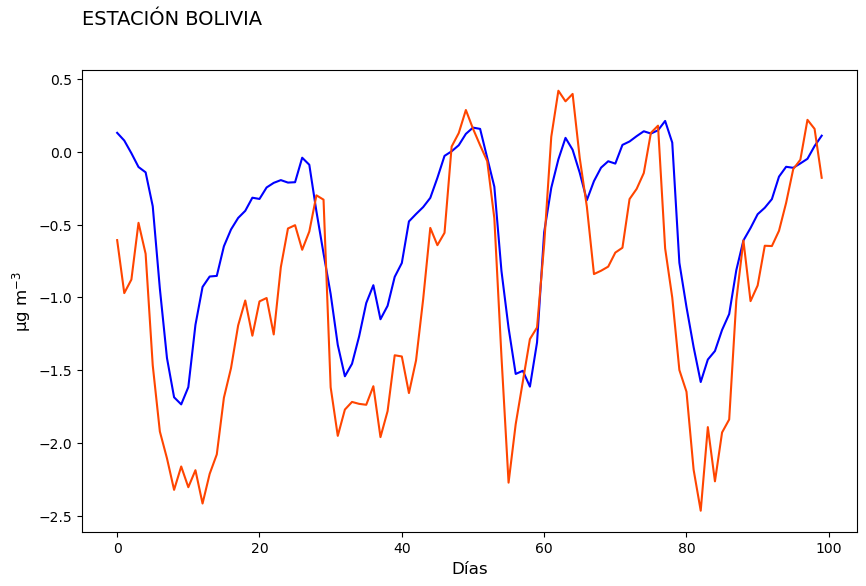

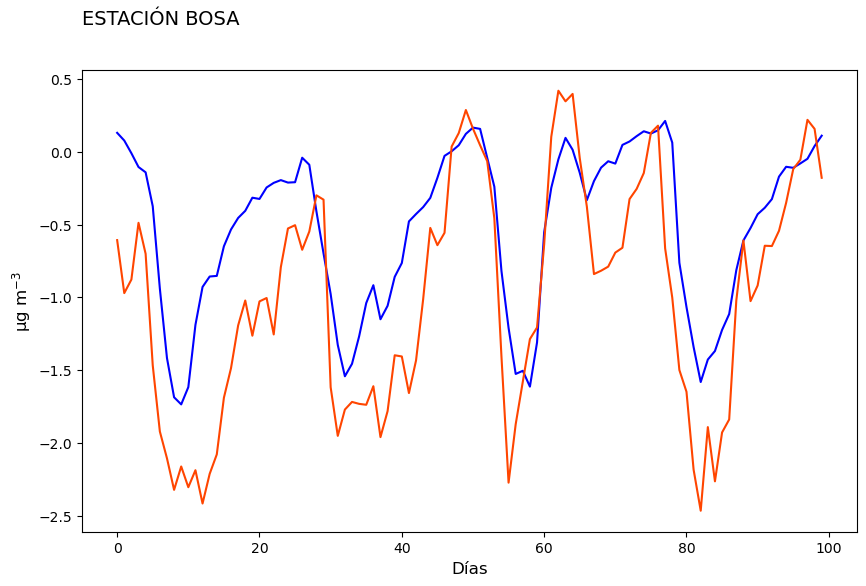

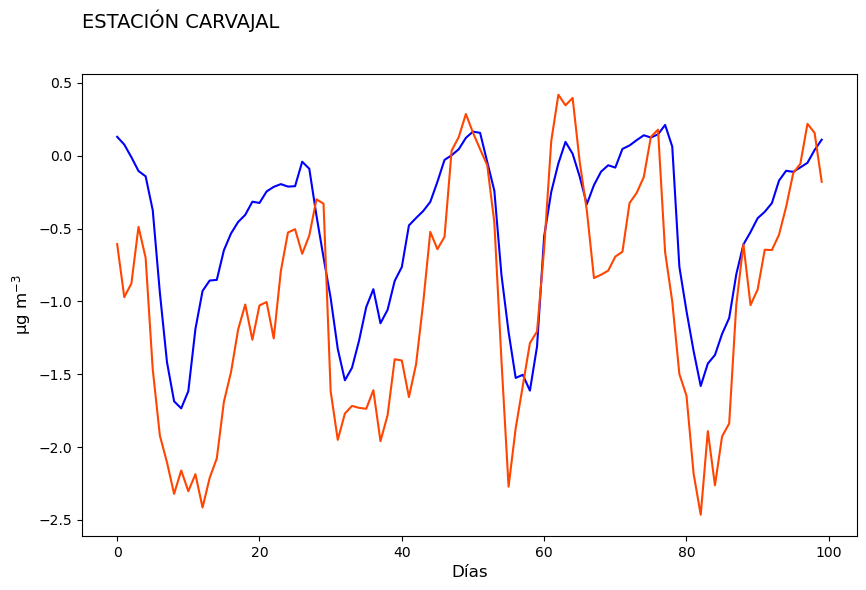

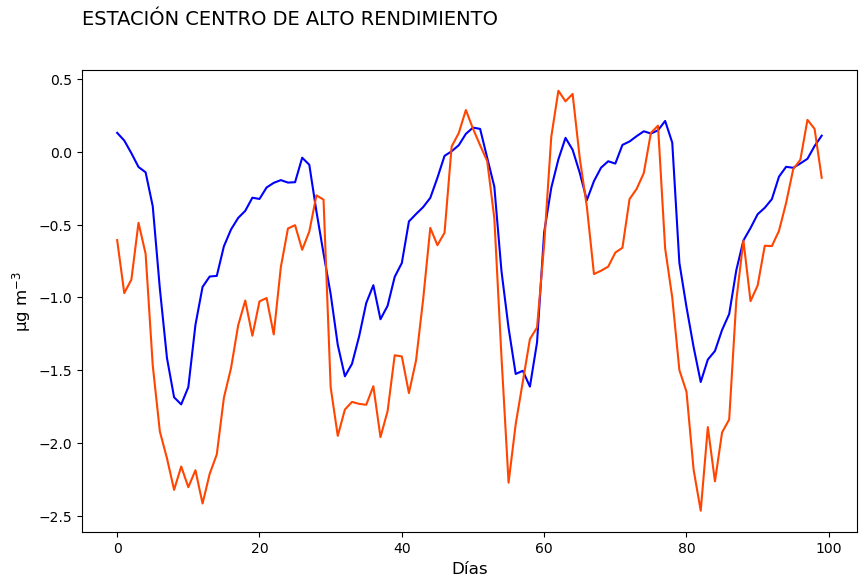

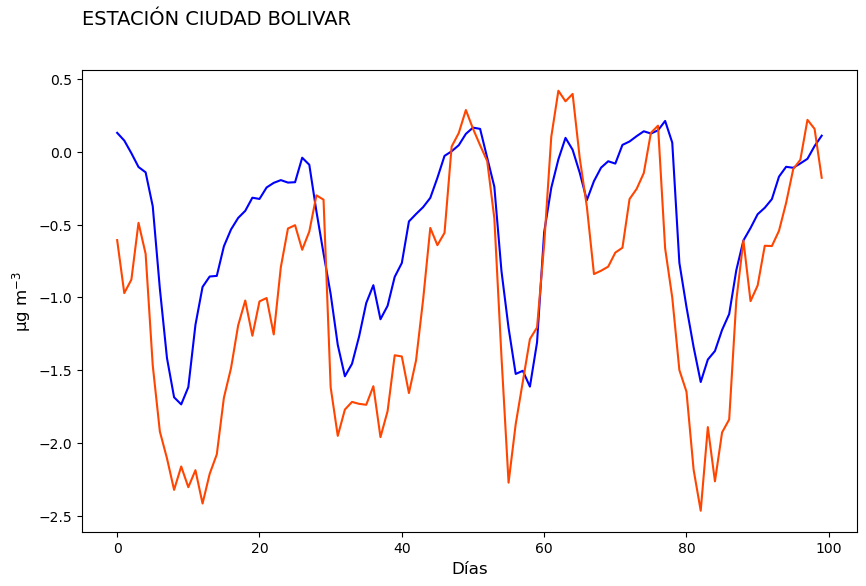

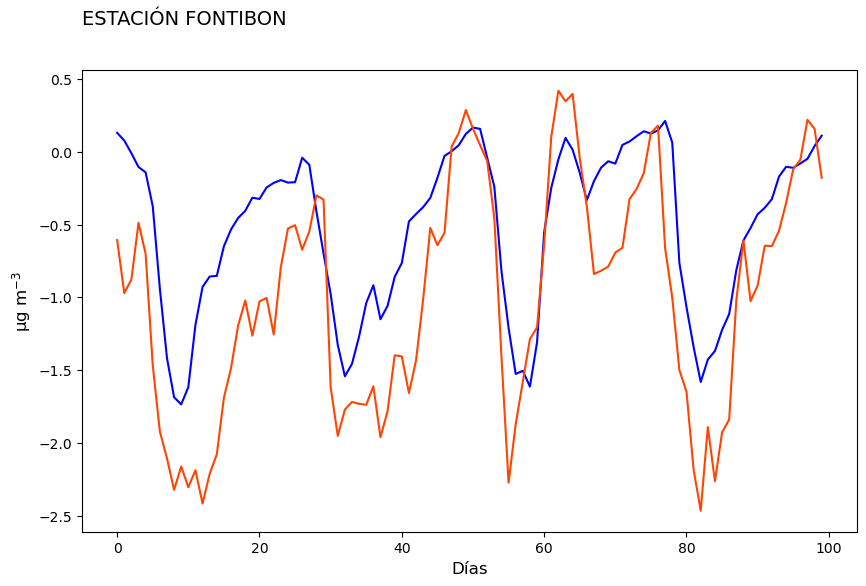

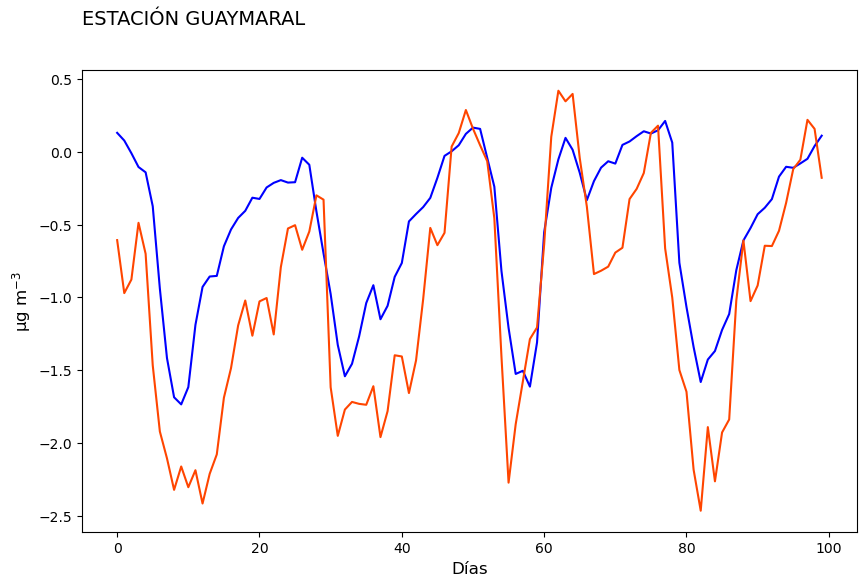

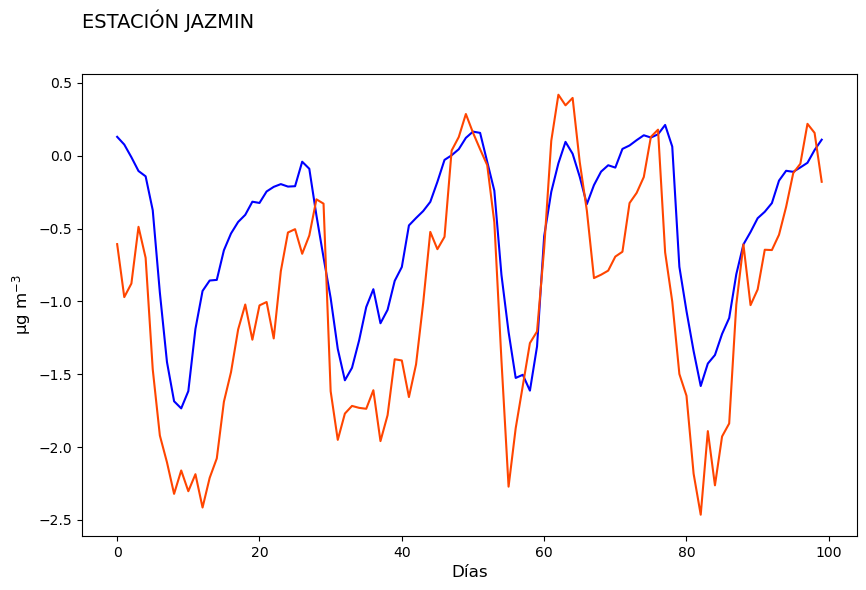

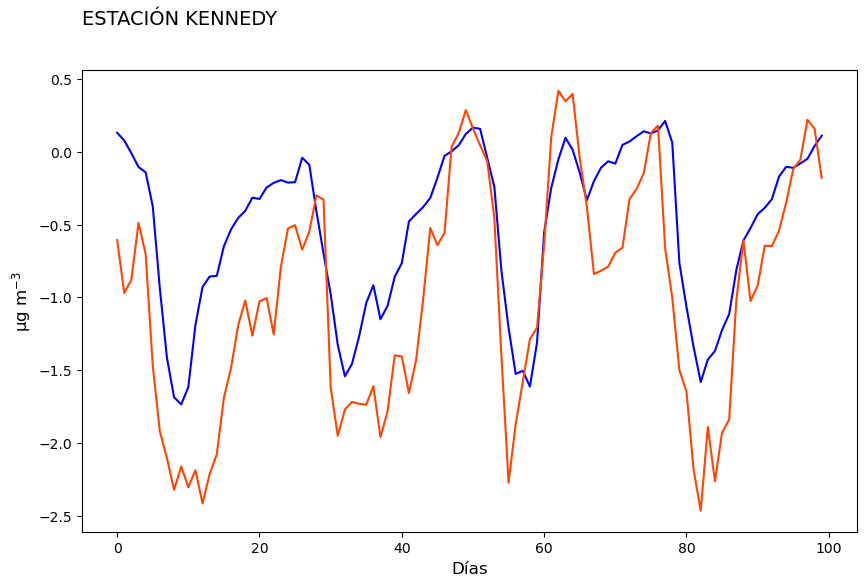

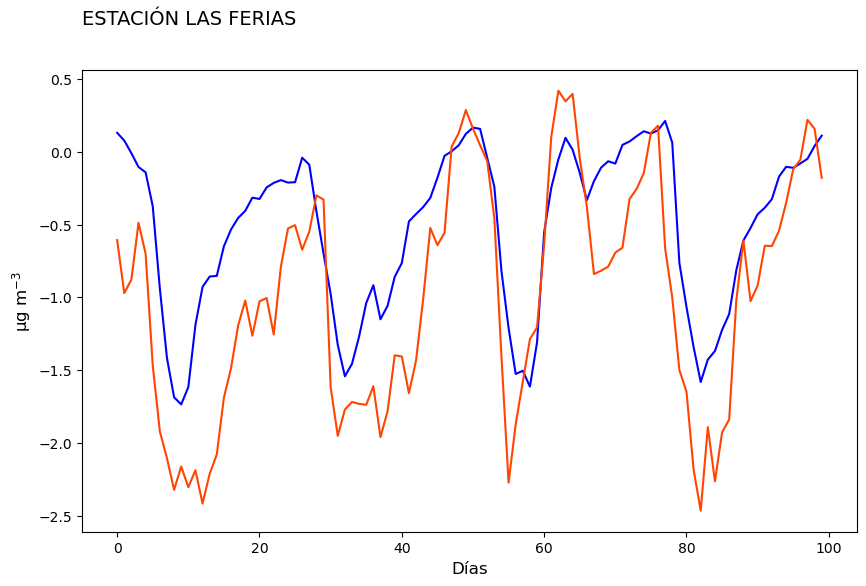

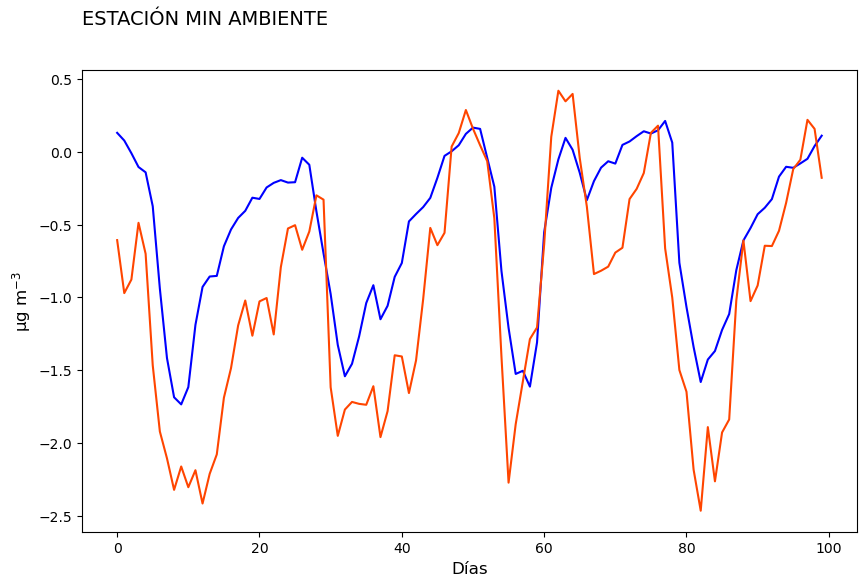

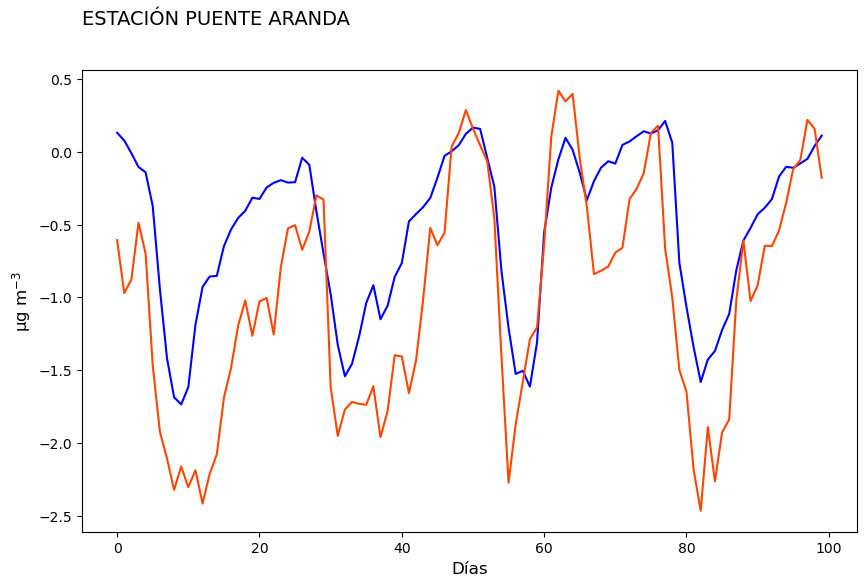

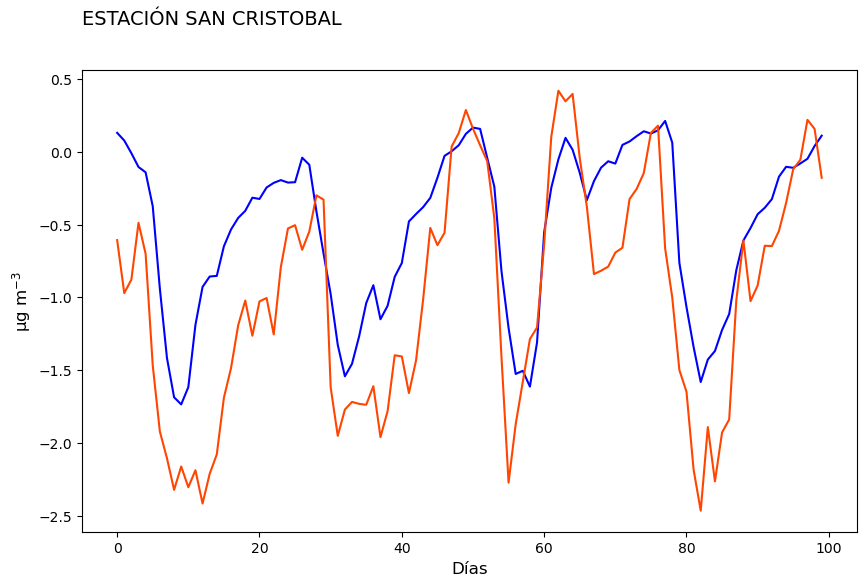

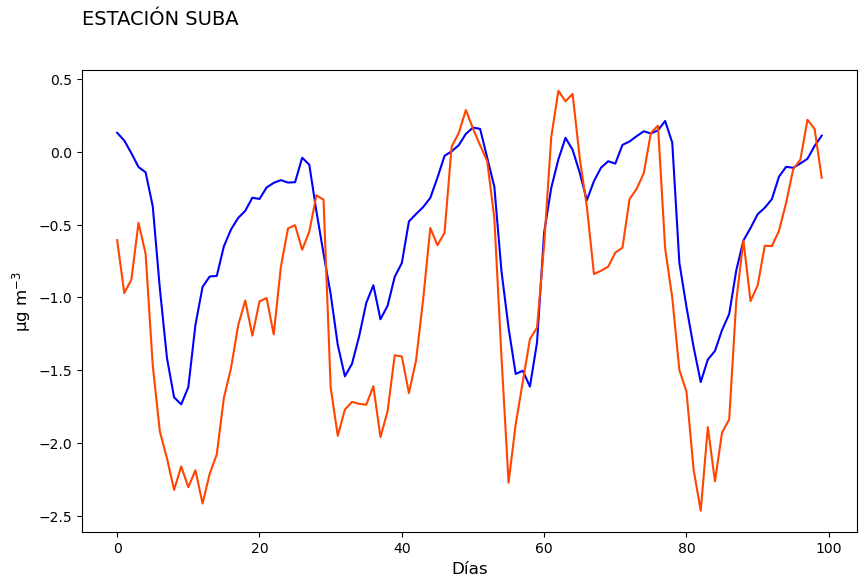

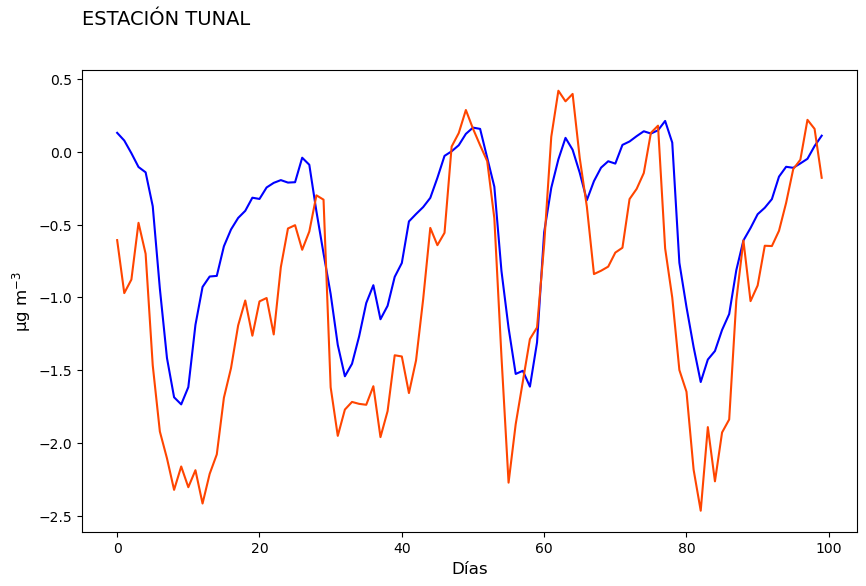

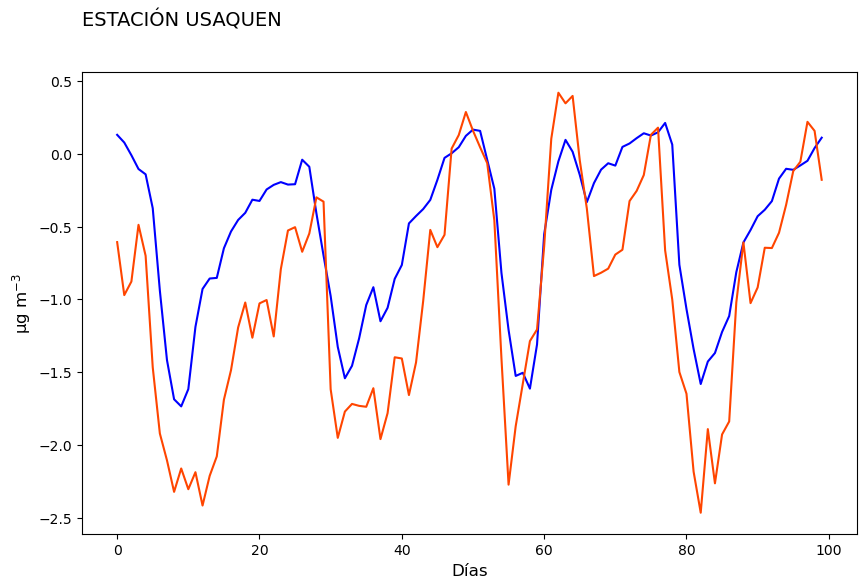

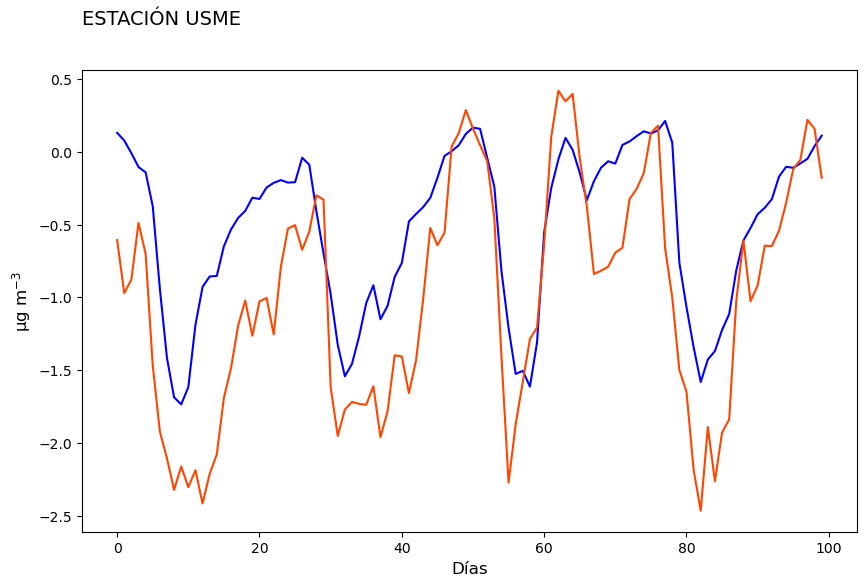

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(12, 12))

variables = ['Predicción O$_{3}$', 'Observado O$_{3}$']

# Colores correspondientes a las variables
colores = ['turquoise', 'blueviolet']

# Bucle para crear subplots y graficar los datos
for i in range(2):
    for j in range(3):
        ax = axs[i, j]
        estacion = estaciones[i * 3 + j]  # Calcula la estación actual
        for k, variable in enumerate(variables):
            if variable == 'O$_{3}$':
                ax.plot(locals()[f'monmean'][estacion], label=variable, color=colores[k])
            elif variable == 'NO':
                ax.plot(locals()[f'monmeanno'][estacion], label=variable, color=colores[k])
            elif variable == 'NO$_{2}$':
                ax.plot(locals()[f'monmeanno2'][estacion], label=variable, color=colores[k])
        ax.set_title(f'{chr(97 + i * 3 + j)}) {estacion}', loc='left', fontsize=25)
        ax.set_yticks(np.arange(5, 31, 5))
        ax.set_xticks(np.arange(1, 13))
        ax.legend(fontsize=19)
        if i == 1:
            ax.set_xlabel('Días', fontsize=21)
            ax.set_xticklabels(ax.get_xticks(), fontsize=19)
        else: 
            ax.set_xticklabels(ax.get_xticks(), visible=False)
       
        if j == 0:
            ax.set_ylabel('μg m$^{-3}$', fontsize=21)
            ax.set_yticklabels(ax.get_yticks(), fontsize=19)
        else: 
            ax.set_yticklabels(ax.get_yticks(), visible=False)

plt.show()

# Itera a través de las estaciones
for estacion in estaciones:
    
    df = pd.read_csv('Predicciones/prediccion_estacion_'+estacion+'.csv', parse_dates=True, index_col=0)
    # Crea una figura y un subplot para la estación actual
    fig_individual = plt.figure(figsize=(10, 6))
    plt.title(f'ESTACIÓN {estacion}', fontsize=14, loc='left', y=1.08)
    
    # Grafica la predicción y los datos reales para los primeros 100 días
    plt.plot(prediccion[0:100], label='Predicción Ozono', color='blue')
    plt.plot(real[0:100], label='Ozono observado', color='orangered')
    
    plt.xlabel('Días', fontsize=12)
    plt.ylabel('μg m$^{-3}$', fontsize=12)
    
    individual_figures.append(fig_individual)  # Agrega la figura individual a la lista

# Combinar las figuras individuales en una sola figura con subtramas
for i, fig in enumerate(individual_figures):
    sub = fig_combined.add_subplot(len(estaciones), 1, i+1)
    plt.title(f'{chr(97 + i * 3 + j)} {estacion}', fontsize=14, loc='left', y=1.08)
    if i == 1:   
        plt.legend(frameon=False, bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=4, fontsize=10)
    sub.axis('off')  # Desactivar ejes para la figura combinada
    sub.imshow(fig)

plt.show()  # Muestra la figura combinada

NameError: name 'j' is not defined

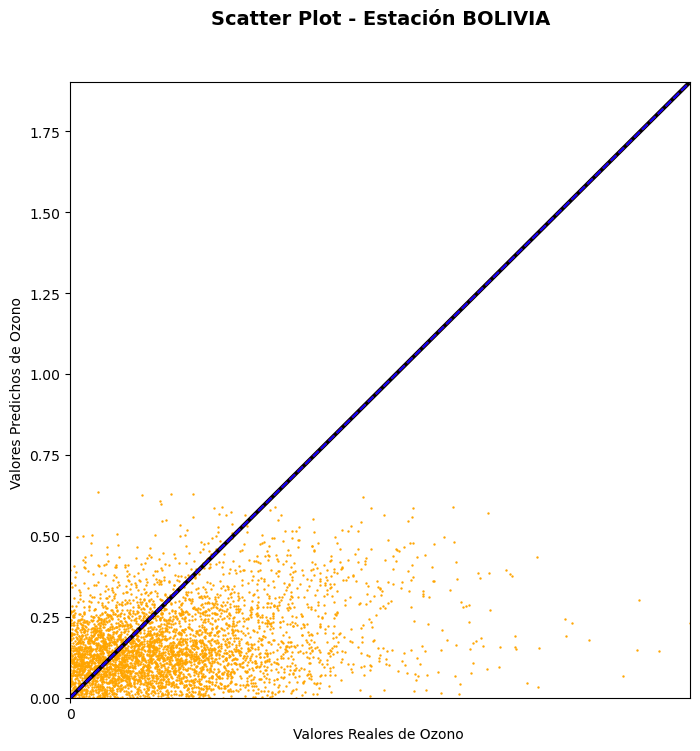

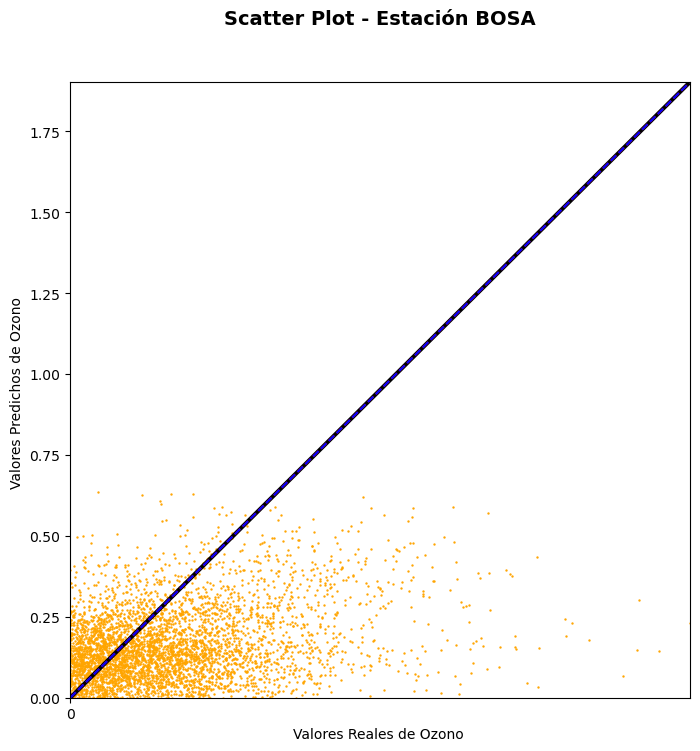

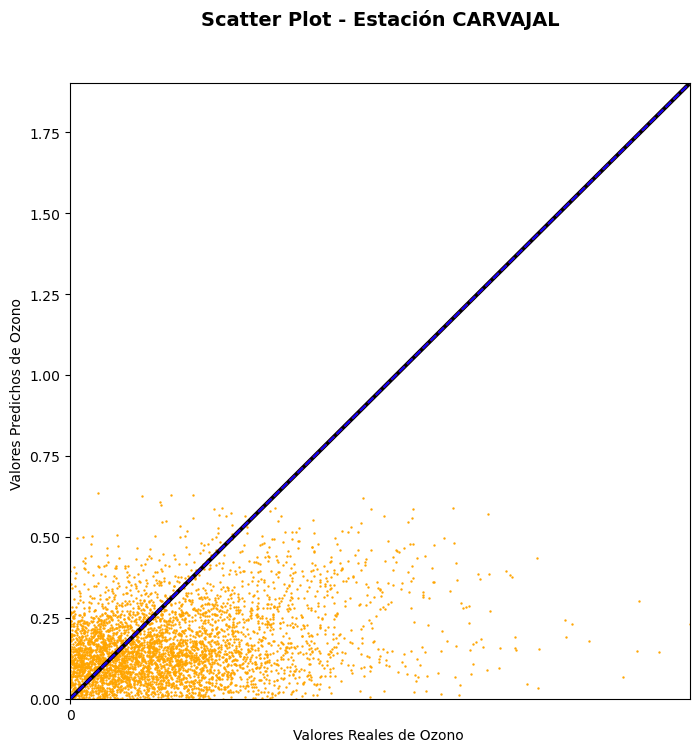

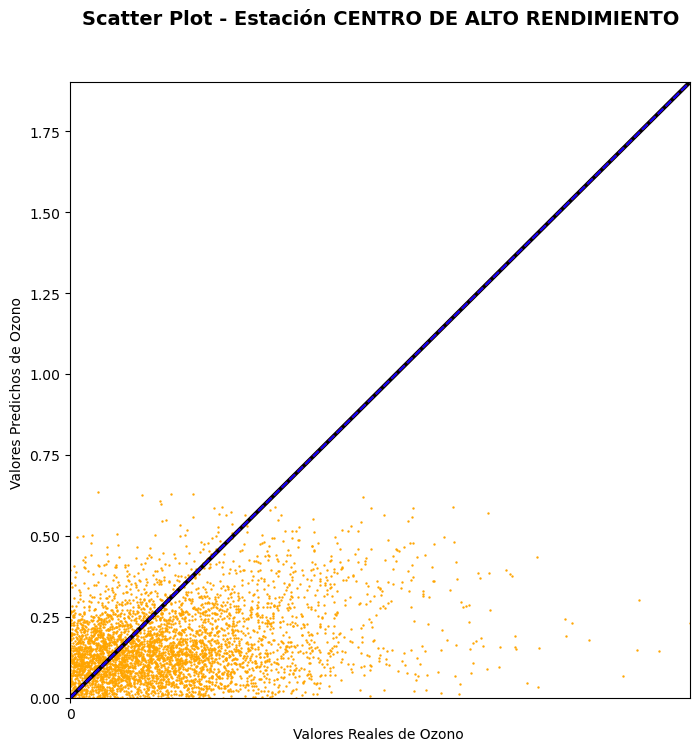

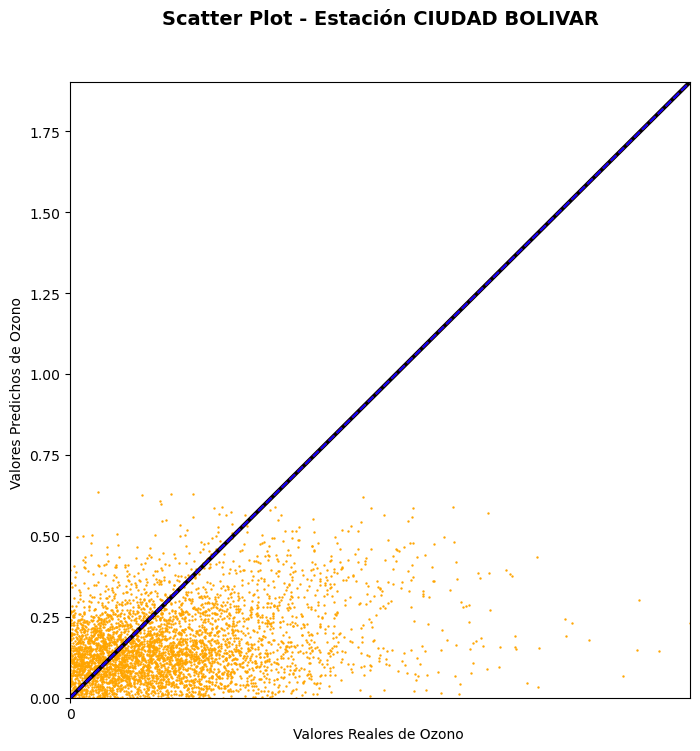

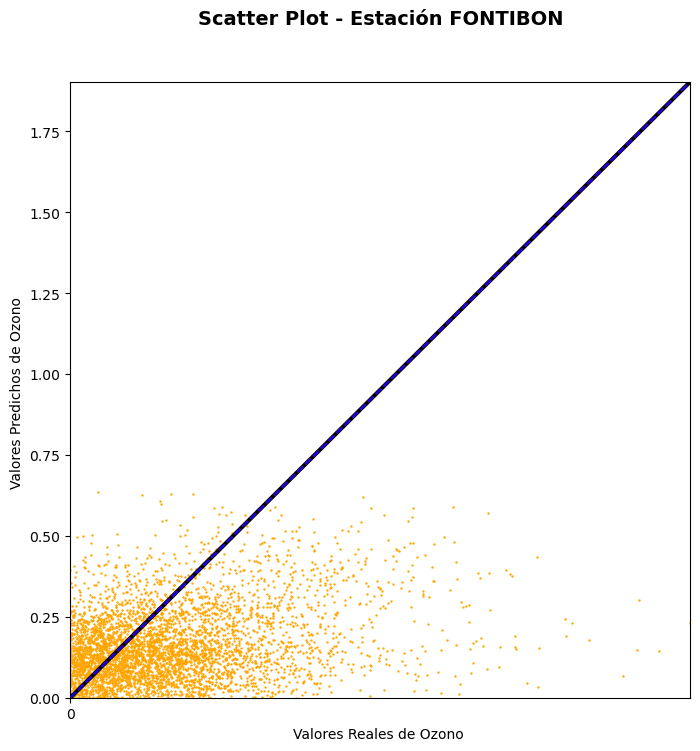

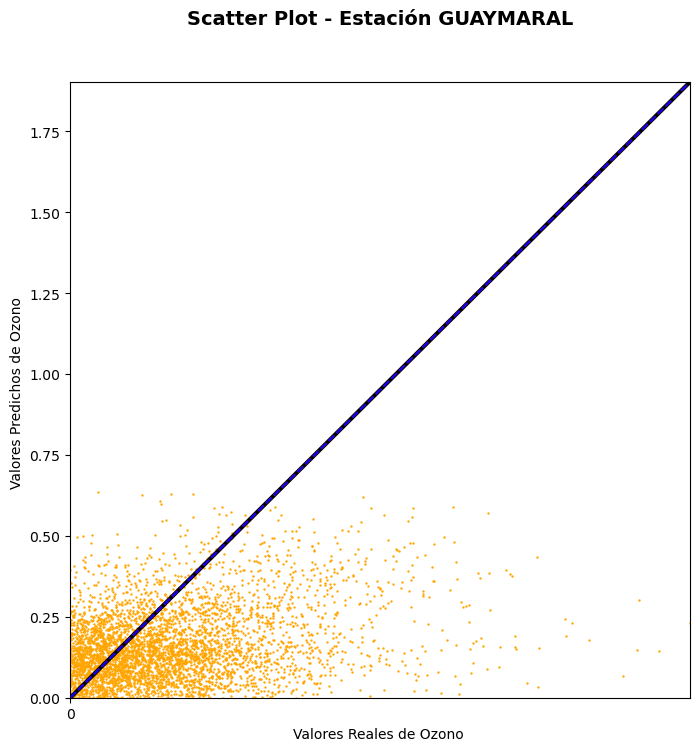

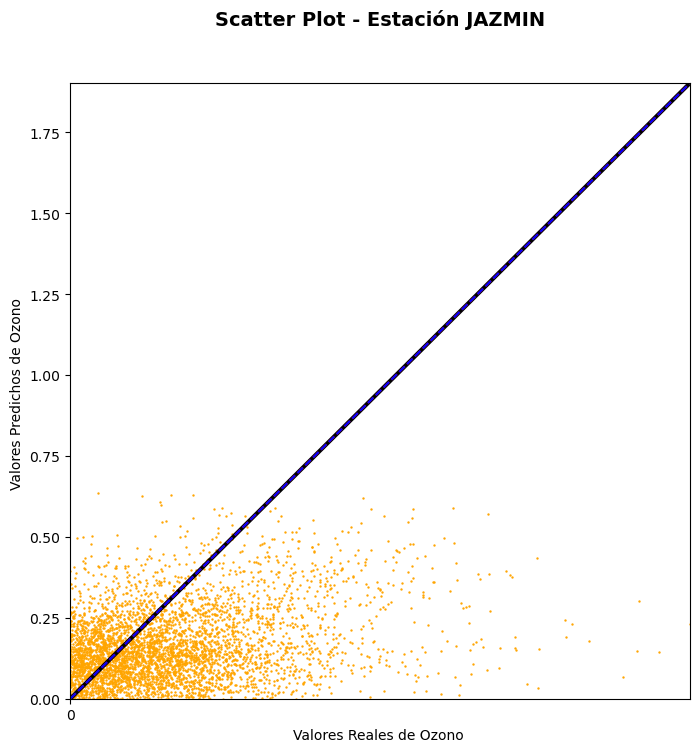

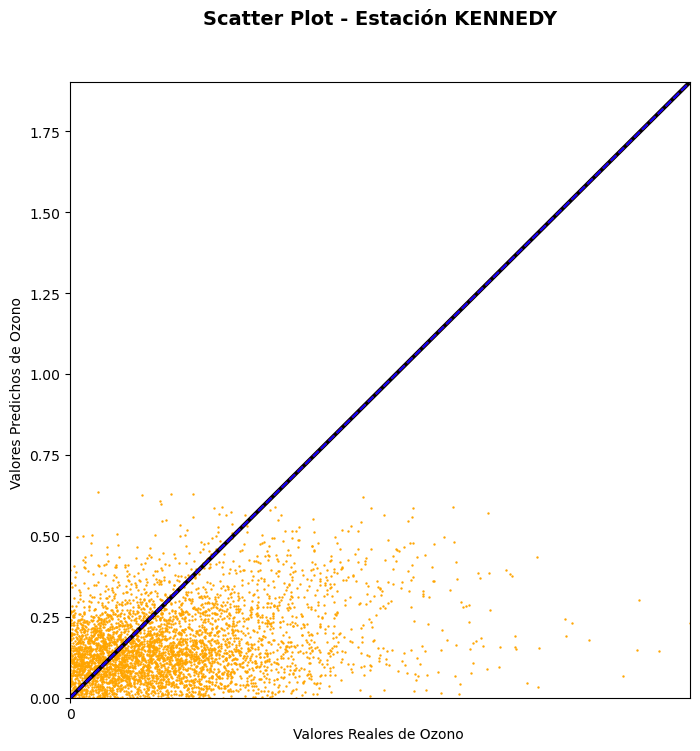

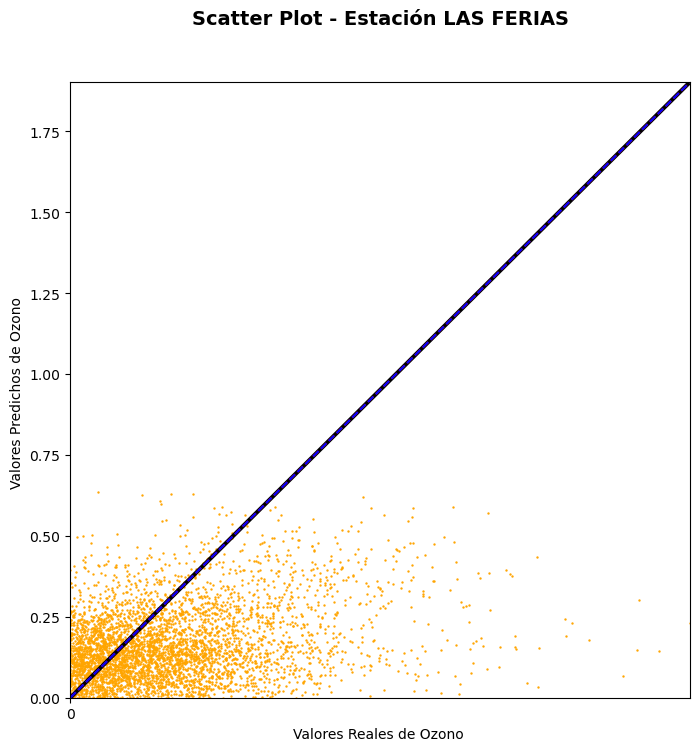

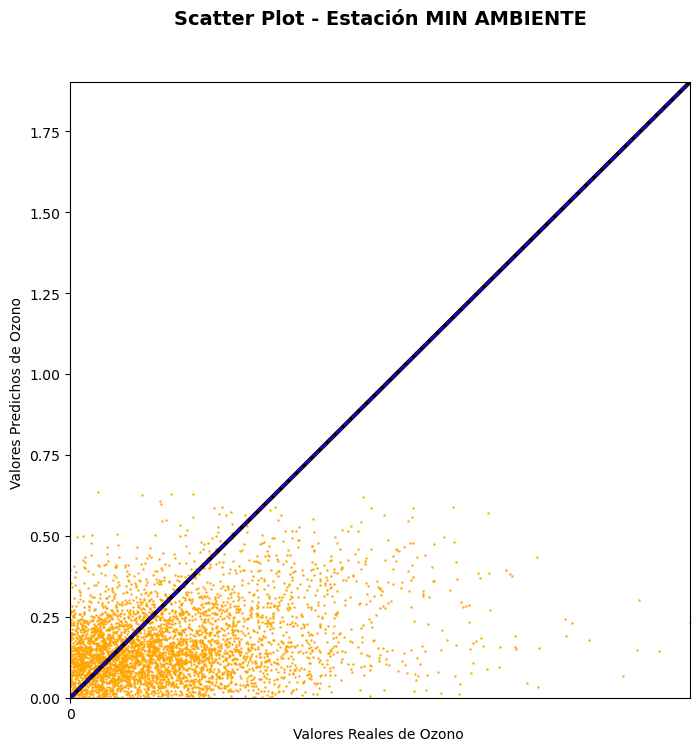

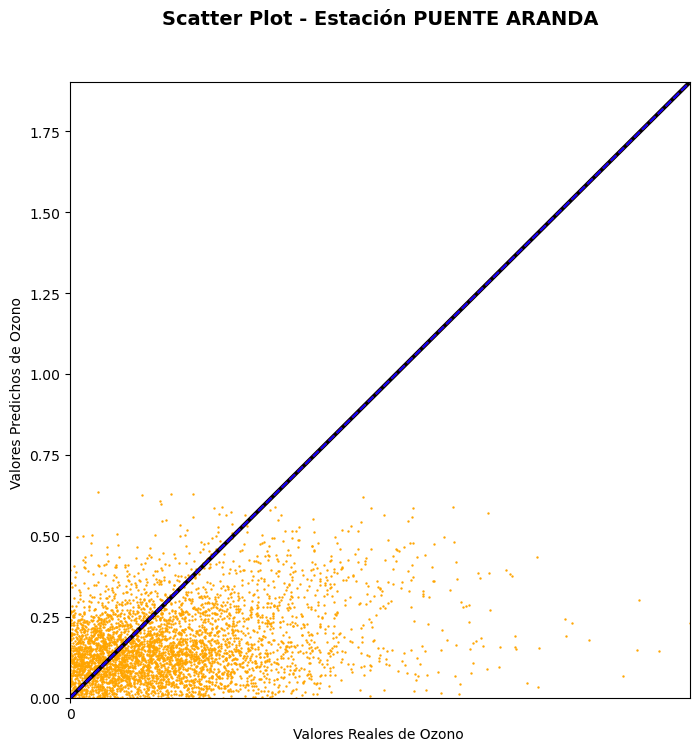

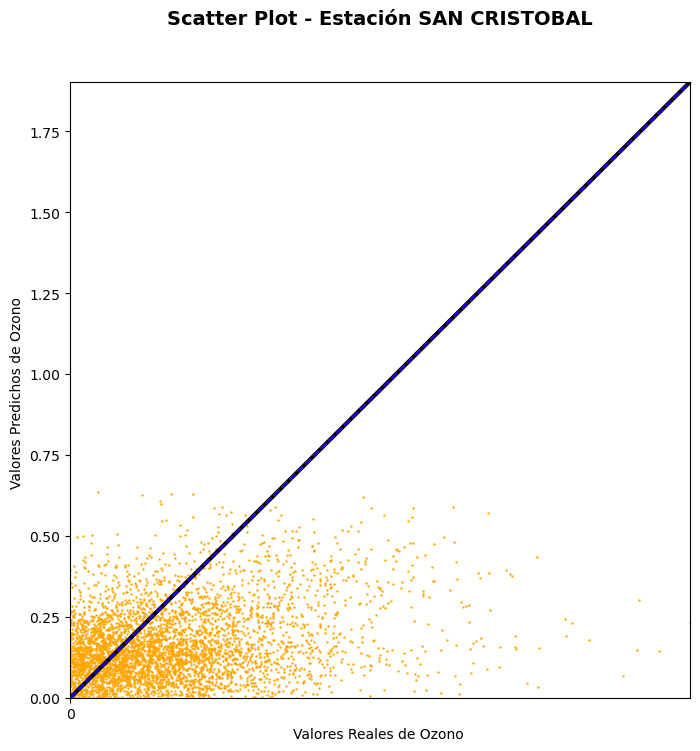

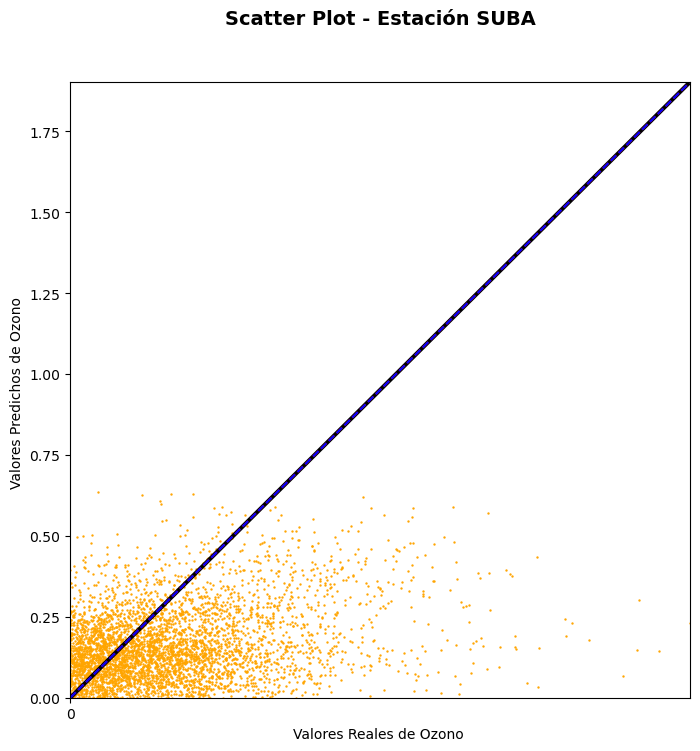

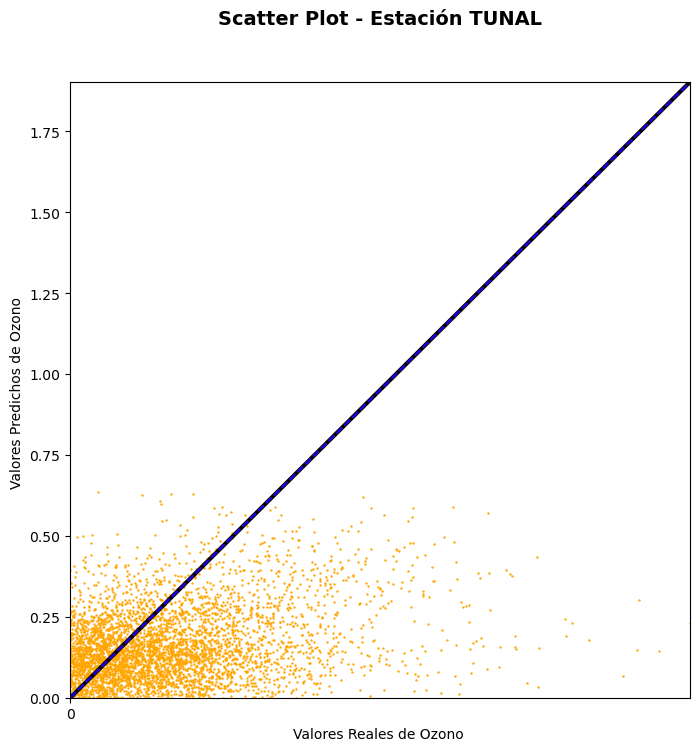

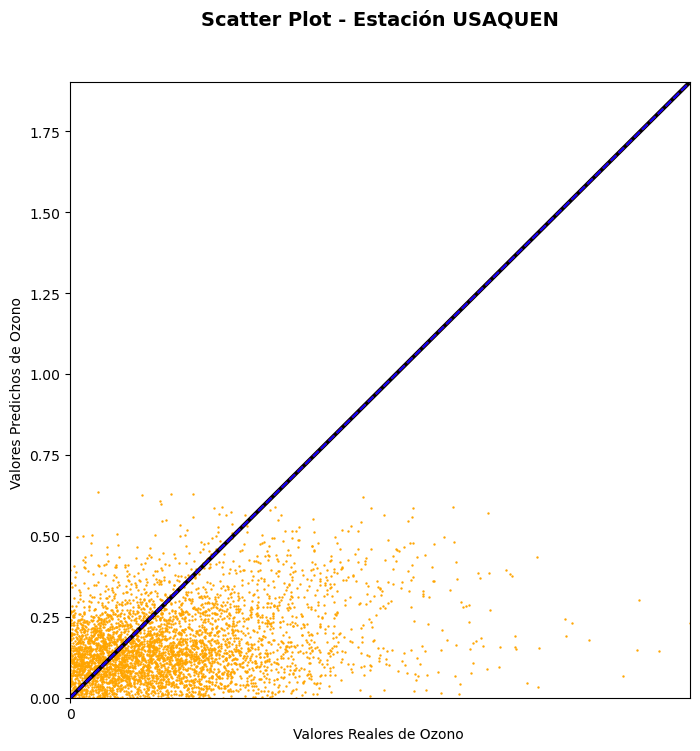

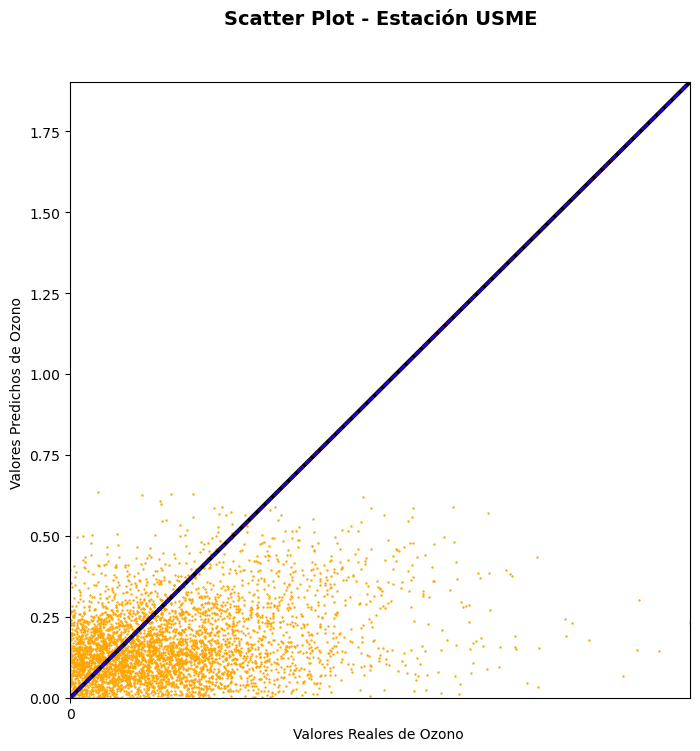

In [15]:
#SCATTER PLOTS

for estacion in estaciones:
   
    ##errores = real - prediccion
    
    # Calcular la desviación estándar de los errores
    ##desviacion = np.std(errores)
    # Crear una figura y un subplot para el scatter plot
    fig_scatter = plt.figure(figsize=(8, 8))
    plt.title(f'Scatter Plot - Estación {estacion}', fontsize=14, fontweight='bold', y=1.08)
    
    # Crear el scatter plot
    plt.scatter(real, prediccion, color='orange', s = 0.5, label='Valores Predichos')
    
    # Línea de desviación
    ymaxmitad= max(max(real), max(prediccion)*0.5)
    ymaxdoble= max(max(real), max(prediccion)*2)
    ymax = max(max(real), max(prediccion))
    plt.plot([0, ymax], [0, ymax], color="black", lw=3, label='Línea de Desviación')
    
    # Líneas de desviación superior e inferior basadas en la desviación estándar
    plt.plot([0, ymax], [0, ymaxmitad], color="red", linestyle='--', label='Línea Superior')
    plt.plot([0, ymax], [0, ymaxdoble], color="blue", linestyle='--', label='Línea Inferior')
    
    plt.xlim(0, ymax)
    plt.ylim(0, ymax)
    plt.xticks(np.arange(0, ymax, 10))
    
    plt.xlabel("Valores Reales de Ozono ")
    plt.ylabel("Valores Predichos de Ozono ")
    
    individual_figures.append(fig_scatter)  # Agrega la figura del scatter plot a la lista

for i, fig in enumerate(individual_figures):
    plt.title(f'{chr(97 + i * 3 + j)} {estacion}', fontsize=14, loc='left', y=1.08)
    if i == 1:   
        plt.legend(frameon=False, bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=4, fontsize=10)
    sub = fig_combined.add_subplot(len(estaciones), 1, i+1)
    sub.axis('off')  
    sub.figure.figimage(fig) 

plt.show() 

Epoch 1/25
1164/1164 - 52s - loss: 0.0193 - accuracy: 0.0000e+00 - val_loss: 0.0167 - val_accuracy: 0.0000e+00 - 52s/epoch - 44ms/step
Epoch 2/25
1164/1164 - 42s - loss: 0.0037 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00 - 42s/epoch - 36ms/step
Epoch 3/25
1164/1164 - 42s - loss: 0.0022 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00 - 42s/epoch - 36ms/step
Epoch 4/25
1164/1164 - 41s - loss: 0.0019 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00 - 41s/epoch - 36ms/step
Epoch 5/25
1164/1164 - 40s - loss: 0.0018 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - 40s/epoch - 34ms/step
Epoch 6/25
1164/1164 - 52s - loss: 0.0016 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00 - 52s/epoch - 44ms/step
Epoch 7/25
1164/1164 - 48s - loss: 0.0016 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00 - 48s/epoch - 41ms/step
Epoch 8/25
1164/1164 - 51s - loss: 0.0015 - accuracy: 0

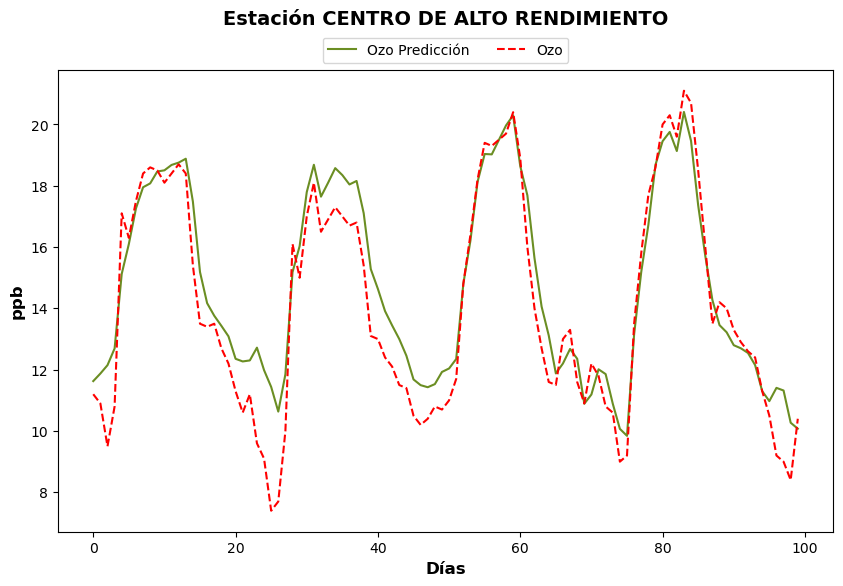

Epoch 1/25
1164/1164 - 69s - loss: 0.0127 - accuracy: 0.0000e+00 - val_loss: 0.0054 - val_accuracy: 0.0000e+00 - 69s/epoch - 60ms/step
Epoch 2/25
1164/1164 - 44s - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0034 - val_accuracy: 0.0000e+00 - 44s/epoch - 37ms/step
Epoch 3/25
1164/1164 - 47s - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - 47s/epoch - 40ms/step
Epoch 4/25
1164/1164 - 49s - loss: 0.0020 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00 - 49s/epoch - 42ms/step
Epoch 5/25
1164/1164 - 49s - loss: 0.0018 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00 - 49s/epoch - 42ms/step
Epoch 6/25
1164/1164 - 45s - loss: 0.0017 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00 - 45s/epoch - 39ms/step
Epoch 7/25
1164/1164 - 44s - loss: 0.0016 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00 - 44s/epoch - 38ms/step
Epoch 8/25
1164/1164 - 53s - loss: 0.0015 - accuracy: 0

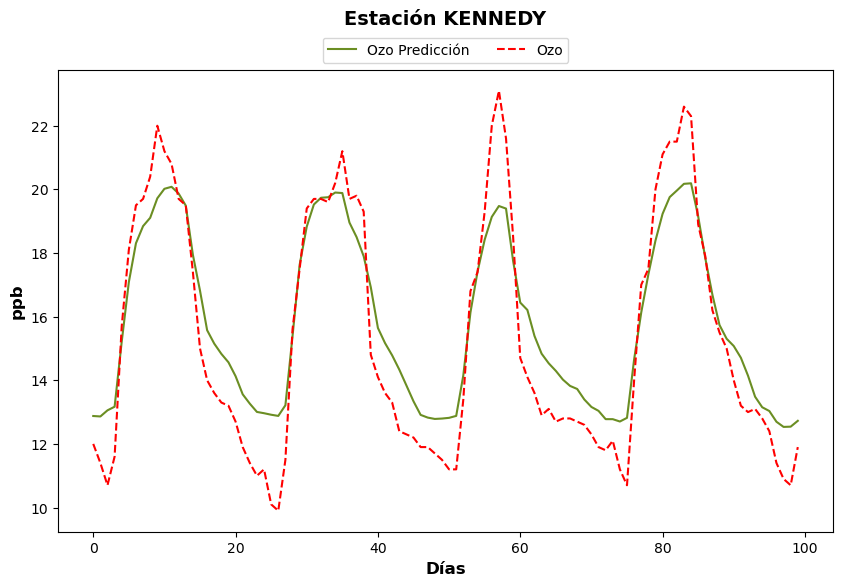

Epoch 1/25
1164/1164 - 57s - loss: 0.0145 - accuracy: 0.0000e+00 - val_loss: 0.0524 - val_accuracy: 0.0000e+00 - 57s/epoch - 49ms/step
Epoch 2/25
1164/1164 - 45s - loss: 0.0051 - accuracy: 0.0000e+00 - val_loss: 0.0075 - val_accuracy: 7.6196e-05 - 45s/epoch - 38ms/step
Epoch 3/25
1164/1164 - 41s - loss: 0.0019 - accuracy: 0.0000e+00 - val_loss: 0.0048 - val_accuracy: 0.0000e+00 - 41s/epoch - 36ms/step
Epoch 4/25
1164/1164 - 42s - loss: 0.0017 - accuracy: 0.0000e+00 - val_loss: 0.0088 - val_accuracy: 0.0000e+00 - 42s/epoch - 36ms/step
Epoch 5/25
1164/1164 - 42s - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - 42s/epoch - 36ms/step
Epoch 6/25
1164/1164 - 39s - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0489 - val_accuracy: 0.0000e+00 - 39s/epoch - 34ms/step
Epoch 7/25
1164/1164 - 45s - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - 45s/epoch - 39ms/step
Epoch 8/25
1164/1164 - 44s - loss: 0.0015 - accuracy: 0

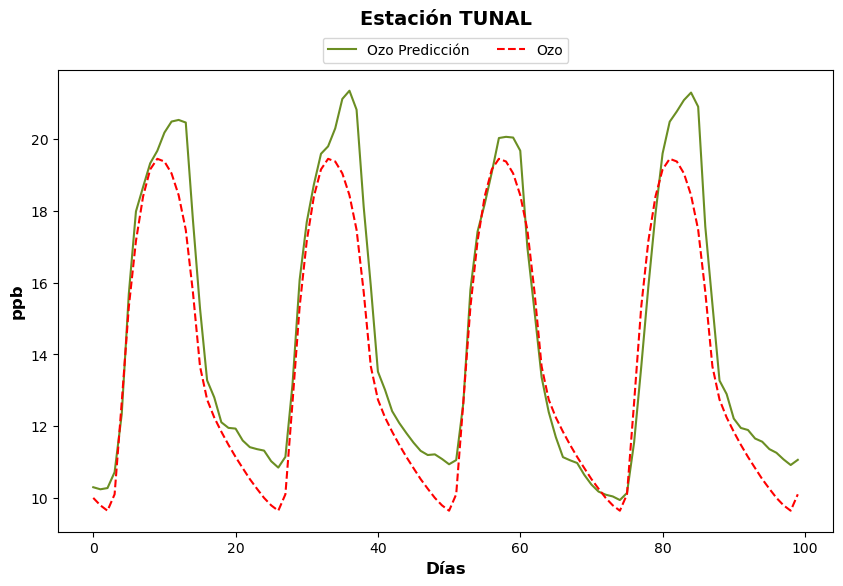

Epoch 1/25
1164/1164 - 64s - loss: 0.0190 - accuracy: 0.0000e+00 - val_loss: 0.0102 - val_accuracy: 0.0000e+00 - 64s/epoch - 55ms/step
Epoch 2/25
1164/1164 - 48s - loss: 0.0031 - accuracy: 0.0000e+00 - val_loss: 0.0084 - val_accuracy: 0.0000e+00 - 48s/epoch - 41ms/step
Epoch 3/25
1164/1164 - 47s - loss: 6.4775e-04 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00 - 47s/epoch - 40ms/step
Epoch 4/25
1164/1164 - 48s - loss: 3.5291e-04 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00 - 48s/epoch - 41ms/step
Epoch 5/25
1164/1164 - 80s - loss: 3.2003e-04 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00 - 80s/epoch - 69ms/step
Epoch 6/25
1164/1164 - 60s - loss: 3.1104e-04 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00 - 60s/epoch - 51ms/step
Epoch 7/25
1164/1164 - 49s - loss: 3.0922e-04 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00 - 49s/epoch - 42ms/step
Epoch 8/25
1164/1164 - 64s - loss: 

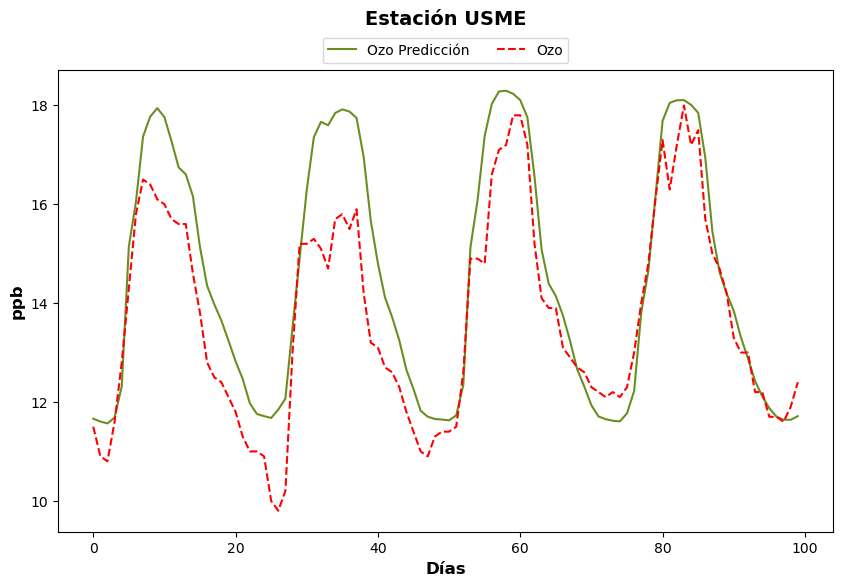

In [18]:
#Para este caso utilice solo las 4 estaciones con variables completas
for estacion in estaciones:
    df_estacion = dataframes_estaciones[estacion]
    
    # Normalizar los datos de la estación actual (df_estacion) y dividir en tren y prueba
    # Esto debe hacerse de nuevo para cada estación
    n_pasos = 24
    escalador = MinMaxScaler(feature_range=(0, 1))
    escalador.fit(df_estacion)
    
    data_nor = escalador.transform(df_estacion)
    data_train = data_nor[0:int(len(df_estacion) * 0.85)]
    data_test = data_nor[int(len(df_estacion) * 0.85):]
    
    X_train, y_train = crear_trenes(data_train)
    X_test, y_test = crear_trenes(data_test)
    
    # Llama a la función de entrenamiento y predicción del modelo
    trained_model = train_and_predict_model(X_train, y_train, X_test, y_test)
    
    # Realiza la predicción para la estación actual
    prediccion = trained_model.predict(X_test)
    
    # Invierte la transformación y obtiene los datos "reales" e "inversión"
    real = invTransform(escalador, y_test, columnas[-1], columnas)
    prediccion = invTransform(escalador, prediccion, columnas[-1], columnas)
    
    # Crea una figura y un subplot para la estación actual
    plt.figure(figsize=(10, 6))
    plt.title(f'Estación {estacion}', fontsize=14, fontweight='bold', y=1.08)
    
    # Grafica la predicción y los datos reales para los primeros 100 días
    plt.plot(prediccion[0:100], label='Ozo Predicción', color='olivedrab')
    plt.plot(real[0:100], label='Ozo', color='red', linestyle='--')
    
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1), ncol=4, fontsize=10)
    plt.xlabel('Días', fontweight='bold', fontsize=12)
    plt.ylabel('ppb', fontweight='bold', fontsize=12)
    
    
    plt.show()

In [13]:
from sklearn.metrics import r2_score,mean_squared_error
r2skill=r2_score(real, prediccion)
bias=np.mean(prediccion)-np.mean(real)
rmse=np.sqrt(mean_squared_error(real, prediccion))
r = np.corrcoef(real, prediccion)
print("r2",r2skill,"bias",bias,"RMSE", rmse, 'r', r[0,1])

r2 0.4083003478941074 bias -0.2949168943039915 RMSE 6.7509038012544655 r 0.6894714065309684


In [49]:
ozo

FECHA      MEAN
0      2013-01-01 00:00:00  7.303781
1      2013-01-01 01:00:00  8.285555
2      2013-01-01 02:00:00  8.027327
3      2013-01-01 03:00:00  6.181696
4      2013-01-01 04:00:00  5.742065
...                    ...       ...
70123  2020-12-31 19:00:00  5.226047
70124  2020-12-31 20:00:00  3.971850
70125  2020-12-31 21:00:00  4.882591
70126  2020-12-31 22:00:00  4.708125
70127  2020-12-31 23:00:00  3.903726

[70128 rows x 2 columns]

In [62]:
ozo = pd.read_csv('SALIDAS/llenado_O3.csv')
df = ozo

df['Time'] = pd.to_datetime(df['FECHA'])
df.set_index('Time', inplace=True)

df = df.resample('8h').mean().resample('d').max()

monmean = df.groupby(df.index.month).mean()
monstd = df.groupby(df.index.month).std()
weekmean = df.groupby(df.index.weekday).mean()
weekstd = df.groupby(df.index.weekday).std()


In [14]:
def errors(M,O, umbral):
    '''This code calculate 9 metrics to evaluate model performance.
    To use it, you only need to pass two arrays, one is the model and
    the other one contain the observations. Be careful with the null values
    and the type of data! It is also important to make a good selection for the
    threshold!, if not the results would not be correct'''
    import numpy as np
    from scipy import stats
    from sklearn.metrics import mean_squared_error

    M_RAYA = np.mean(M)
    O_RAYA = np.mean(O)

    nmb = (np.sum(M - O)/np.sum(O)) * 100
    rmse = np.sqrt(mean_squared_error(O,M))
    r2 = (np.sum((M - M_RAYA) * (O - O_RAYA))/np.sqrt(np.sum((M - M_RAYA)**2) * np.sum((O - O_RAYA)**2)))**2
    fac2 = len([i for i in  M/O  if 0.5 <= i and i <=2])/ len(M)
    fac2 = fac2*100
    ioa = 1 - (np.sum((M - O)**2))/np.sum((np.abs(M - O_RAYA) + np.abs(O - O_RAYA))**2) 
    mb = np.mean((M - O))
    rho = stats.spearmanr(M,O)

    na = len([i for i in np.arange(0,len(M),1) if O[i] < umbral and M[i] > umbral])
    nb = len([i for i in np.arange(0,len(M),1) if O[i] > umbral and M[i] > umbral])
    nc = len([i for i in np.arange(0,len(M),1) if O[i] < umbral and M[i] < umbral])
    nd = len([i for i in np.arange(0,len(M),1) if O[i] < umbral and M[i] < umbral]) 
    
    if nb + nd > 0:  
        hit = (nb/(nb + nd))*100
    else:
        hit = 0
    if na + nb > 0:
        far = (na/(na + nb))*100
    else:
        far = 0
    if na + nb + nc + nd > 0:
        poc = ((nb + nc)/(na + nb + nc + nd))*100
    else:
        poc = 0

    return(round(nmb,2),round(rmse,2),round(rho[0],2),round(fac2,2),round(ioa,2),
           round(mb,2),round(hit,2),round(far,2),round(poc,2))

In [15]:
##Errores según el orden del return##
nmb, rmse, rho, fac2, ioa, mb, hit, far, poc = errors(prediccion, real, 10)
nmb, rmse, rho, fac2, ioa, mb, hit, far, poc

(-2.21, 6.75, 0.81, 94.74, 0.83, -0.29, 54.78, 11.75, 65.57)

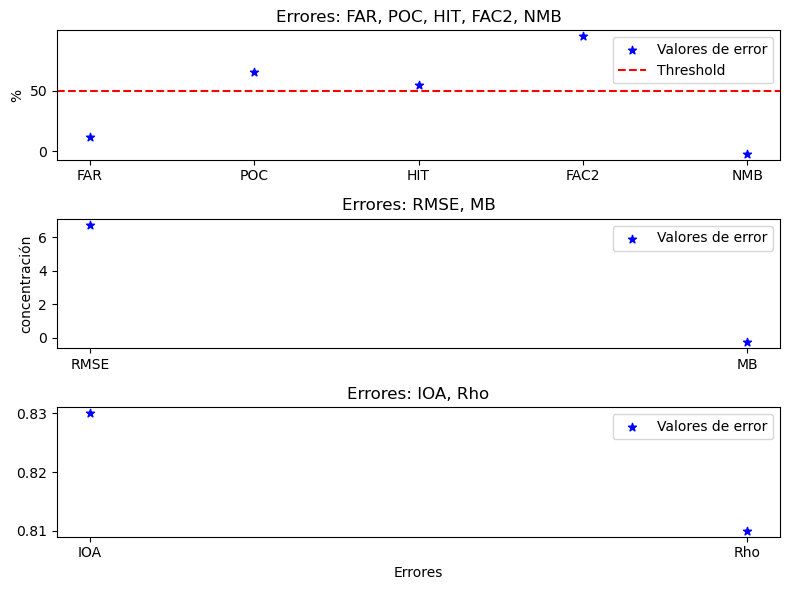

In [37]:
from matplotlib.gridspec import GridSpec

# Valores de los errores
errores1 = ['FAR', 'POC', 'HIT', 'FAC2', 'NMB']
errores2 = ['RMSE', 'MB']
errores3 = ['IOA', 'Rho']

# Valores del threshold
threshold = 50

# Valores de los errores
valores_errores1 = [far, poc, hit, fac2, nmb]
valores_errores2 = [rmse, mb]
valores_errores3 = [ioa, rho]

# Crear subgráficas
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8, 6))
GridSpec(3,3, left=0.05, right=0.975, hspace=0.2, wspace=0.23, top=0.9, bottom=0.1)

# Configurar la primera subgráfica
ax1.scatter(errores1, valores_errores1, marker='*', color='b', label='Valores de error')
ax1.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
ax1.set_title('Errores: FAR, POC, HIT, FAC2, NMB')
ax1.set_ylabel('%')
ax1.legend()

# Configurar la segunda subgráfica
ax2.scatter(errores2, valores_errores2, marker='*', color='b', label='Valores de error')
# ax2.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
ax2.set_title('Errores: RMSE, MB')
ax2.set_ylabel('concentración')
ax2.legend()

# Configurar la tercera subgráfica
ax3.scatter(errores3, valores_errores3, marker='*', color='b', label='Valores de error')
ax3.set_title('Errores: IOA, Rho')
ax3.set_xlabel('Errores')
ax3.legend()

# Ajustar el espaciado entre las subgráficas
plt.tight_layout()

# Mostrar las subgráficas
plt.show()

In [ ]:
varis = [ 'Ozone_2021']
#varis = ['Ozone_2021']
threshold = 75
file = True
all_cont = []
### Here we read the data, calculate the daymean and remove the data with less than 75% of representation
### This for each pollutant
##for var in varis:
 ##   print('##### '+var+' #####')
 ##   cont = daymean_data(var, threshold, file)
 ##   all_cont.append(cont)

In [ ]:
### Benchmarcks and thresholds (Revisar donde se definió esta parte)
bench = {'PM$_{10}$':[30, 70, 0.5, 30, 0.5, 15, 60, 40, 50],
         'PM$_{2.5}$':[30, 15, 0.5, 50, 0.5, 10, 60, 40, 50], 
         'O$_{3}$':[15, 35, 0.5, 35, 0.5, 15, 60, 40, 50],
         'NO$_{2}$':[15, 70, 0.5, 35, 0.5, 30],
         'NO':[15, 35, 0.5, 35, 0.5, 15],
         'SO$_{2}$':[10, 24, 0.5, 30, 0.5, 10]}

In [ ]:
###(Revisar, ya que esta grafica por ciudades)
errores = ['NMB','RMSE','Rho','FAC2','IOA','MB','HIT','FAR','POC']
varis2 = ['Ozone_2021']
varis1 = ['O$_{3}$', 'NO$_{2}$', 'NO', 'SO$_{2}$']
units = ['%','\u03bcg m$^{-3}$','','%','','\u03bcg m$^{-3}$','%','%','%']
threshold = [30,10,50,18.75,15,30]

dic_error = {}
for var in varis2:
    dic_error[var] = []

for i,obs in enumerate(all_cont):
    erro = np.ones((len(obs.columns),9))*np.nan
    fig = plt.figure(figsize=(20,10))
    gs = GridSpec(3,3, left=0.05, right=0.975, hspace=0.2, wspace=0.23, top=0.9, bottom=0.1)
    for j,col in enumerate(obs.columns):
        O = np.array(obs[col])
        M = np.array(all_cams[i][col])
        erro[j,:] = errors(M,O, threshold[i])
    dic_error[varis2[i]].append(erro)
    if i > 2:
        nerr = 6
        xla_pr = 3
    else:   
        nerr = 9 
        xla_pr = 6
    for k in range(nerr):
        ax=subplot(gs[k])
        plt.bar(np.arange(1,len(obs.columns)+1),erro[:,k], color = 'lightsteelblue', edgecolor='k')
        plt.title(errores[k], fontweight = 'bold')
        plt.ylabel(units[k], fontsize = 12)
        plt.xticks(np.arange(1,len(obs.columns)+1),obs.columns, fontsize = 12, rotation = 90)
        plt.yticks(fontsize = 12)
        if k < xla_pr:
            ax.xaxis.set_major_formatter(NullFormatter())
        plt.grid(linestyle=':', linewidth=0.7, axis = 'y')
        plt.axhline(bench[varis1[i]][k], color = 'red', linestyle = ':')
        if k == 0 or k == 2 or k == 5:
            plt.axhline(bench[varis1[i]][k]*(-1), color = 'red', linestyle = ':')
    #plt.suptitle('Pollutant: '+varis1[i], fontsize = 18, y = 0.98, fontweight = 'bold')
    plt.savefig('Figures/'+varis2[i]+'_plot.jpg', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()